# Analysis of Ultimatum game to maximize an individuals payoff
**Original Study**
- Conducted by James Andreoni and Hal Varian

>Resources
- Full paper can be found here http://www.pnas.org/content/96/19/10933.full
- Attiyeh, G., Franciosi, R. & Isaac, R. M. (1999) Public Choice, in press.
- Bagnoli M, Ben-David S, McKee M(1992) J Public Econ 47:85–106.
-  Chen Y, Plott C R(1996) J Public Econ 59:335–364
- Jonathan Levin (2006) http://web.stanford.edu/~jdlevin/Econ%20286/Experimental.pdf

**Overview**
- The Ultimatum game is an extension of the classic economic thought experiment of Prisoner's Dilemma. To summarize, Prisoner's Dilemma is a situation between two people where each person has the option to defeat of cooperate. The traditional example is given in the following example. Imagine you were brought into a police station to be investigated for a crime. In the other room is your friend who was also being questioned. In the room, you have two options, defect and tell the officers that your friend commited the crime of cooperate with your friend and do no tell the police anything. You friend also has these options. The nash equilibirum is for both parties to stay silent. 
- Even with the nash equlibirum evident, studies have shown that even with incentives to cooperate subjects reach nash equilibirum 10% (Attiyeh et al.), around 20% ( Chen and Plott), and 54% (Bagnoli and McKee) of the time.

> Prionser's Dilemma outlined below

![alt text](prisoners_dilemma.jpg "Title")

**Ultimatum Game**
- The study expanded upon the traditional prisoner's dilemma by first training subjects on a variant of prisoner's dilemma called the ultimatum game. A brief overview of this game is as follows. Imagine you are sitting across the table from another person. In the middle of you is a pot of money. Each person is labeled of either Proposer or Responder. The Proposer can choose how to split the pot of money, while the Responder can decide whether to accept this split or reject this split. If the Responder accepts the split, both subjects receive money; however, if the Responder rejects the split than neither party receives any money.
- However, offers are rejected about 15-20% of the time (Levin).

![alt text](results_of_ultimatum.png "Title")


** Alternative to the game **
- This experiment used two stages; the first was a traditional ultimatum game, where as the second was the ultimatum game where subjects where allowed to offer a non-negative number to the other person to accept their offer. Each player could oer to "Pay for Push". That is each player independently
named an amount that he would pay the other player if the other player played his Push card.
- In this study, participants were allowed to push (which meant giving the other person the amount of money represented by the number on the card) or pull (meaning you take the amount of money from the pot).
- Below is the screen the subjects saw when performing this study.
![alt text](game_setup.png "Title")

** Analysis**
- This project will used several machine learning techniques to see 
    - 1) How to maximize your own payoff (versus total payout) throught the different rounds of play
    - 2) Which factors are the most important to maximize your payoff (versus total payoff)
    - 3) Test the accuracy of different algorithms to answer the questions above.
- The is a supervised regression machine learning problem 
- The number of split for training and testing is determined by the user. The trainval split is used to create new train and validate splits. The train split is used to build the model, the validate is used to test the model, and this process is repeated from the initial split of trainval. Finally, the test split is used to evaluate the model (but this data is never used to build the model).

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model_testing import Model_Testing_Regression
%pylab inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from model_testing import Model_Testing_Regression
from  sklearn.ensemble import GradientBoostingRegressor
%load_ext autoreload
import xgboost
from scipy.spatial.distance import euclidean
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EDA on the data

In [2]:
cols = 'expernum,rd,time,sub,oppnt,myside,opptside,mypush,mypull,\
opptpush,opptpull,mychoice,opptchoice,mychoicecard,opptchoicecard,mypayoff,opptpayoff,totalpayoff'.split(',')

In [3]:
ultimatum_df = pd.read_table('preplay_data.txt',names=cols)

In [4]:
ultimatum_df.head()

,expernum,rd,time,sub,oppnt,myside,opptside,mypush,mypull,opptpush,opptpull,mychoice,opptchoice,mychoicecard,opptchoicecard,mypayoff,opptpayoff,totalpayoff
0,1,1,23,1,6,0,0,6,4,7,3,0,1,4,7,11,0,11
1,1,1,26,6,1,0,0,7,3,6,4,1,0,7,4,0,11,11
2,1,1,30,4,7,0,0,6,4,7,3,0,0,4,3,4,3,7
3,1,1,35,7,4,0,0,7,3,6,4,0,0,3,4,3,4,7
4,1,1,38,5,2,0,0,7,3,6,4,1,1,7,6,6,7,13


In [5]:
new_cols = 'expernum,rd,myside,opptside,mypush,mypull,\
opptpush,opptpull,mychoice,mychoicecard,mypayoff,opptpayoff,totalpayoff'.split(',')

- Remove the columns that are not meaningful for this analysis and columns that you would not see as a subject.
    - Sub (subject number)
    - oppnt (oppnt number)
    - time
    - opptchoice
    - opptchoice card

  

In [6]:
ultimatum_df = ultimatum_df.loc[:,new_cols]


In [7]:
ultimatum_df.head()

,expernum,rd,myside,opptside,mypush,mypull,opptpush,opptpull,mychoice,mychoicecard,mypayoff,opptpayoff,totalpayoff
0,1,1,0,0,6,4,7,3,0,4,11,0,11
1,1,1,0,0,7,3,6,4,1,7,0,11,11
2,1,1,0,0,6,4,7,3,0,4,4,3,7
3,1,1,0,0,7,3,6,4,0,3,3,4,7
4,1,1,0,0,7,3,6,4,1,7,6,7,13


In [8]:
ultimatum_df.describe()

,expernum,rd,myside,opptside,mypush,mypull,opptpush,opptpull,mychoice,mychoicecard,mypayoff,opptpayoff,totalpayoff
count,1920.00000,1920.000000,1920.000000,1920.000000,1920.00000,1920.00000,1920.00000,1920.00000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,3.50000,20.500000,2.093229,2.093229,6.50000,3.50000,6.50000,3.50000,0.412500,4.816667,4.816667,4.816667,9.633333
std,1.70827,11.546404,2.027728,2.027728,0.50013,0.50013,0.50013,0.50013,0.492412,1.570883,2.584221,2.584221,2.247559
min,1.00000,1.000000,0.000000,0.000000,6.00000,3.00000,6.00000,3.00000,0.000000,3.000000,0.000000,0.000000,7.000000
25%,2.00000,10.750000,0.000000,0.000000,6.00000,3.00000,6.00000,3.00000,0.000000,3.000000,3.000000,3.000000,7.000000
50%,3.50000,20.500000,2.000000,2.000000,6.50000,3.50000,6.50000,3.50000,0.000000,4.000000,4.000000,4.000000,9.000000
75%,5.00000,30.250000,4.000000,4.000000,7.00000,4.00000,7.00000,4.00000,1.000000,6.000000,7.000000,7.000000,11.000000
max,6.00000,40.000000,10.000000,10.000000,7.00000,4.00000,7.00000,4.00000,1.000000,7.000000,13.000000,13.000000,13.000000


In [9]:
ultimatum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 13 columns):
expernum        1920 non-null int64
rd              1920 non-null int64
myside          1920 non-null int64
opptside        1920 non-null int64
mypush          1920 non-null int64
mypull          1920 non-null int64
opptpush        1920 non-null int64
opptpull        1920 non-null int64
mychoice        1920 non-null int64
mychoicecard    1920 non-null int64
mypayoff        1920 non-null int64
opptpayoff      1920 non-null int64
totalpayoff     1920 non-null int64
dtypes: int64(13)
memory usage: 195.1 KB


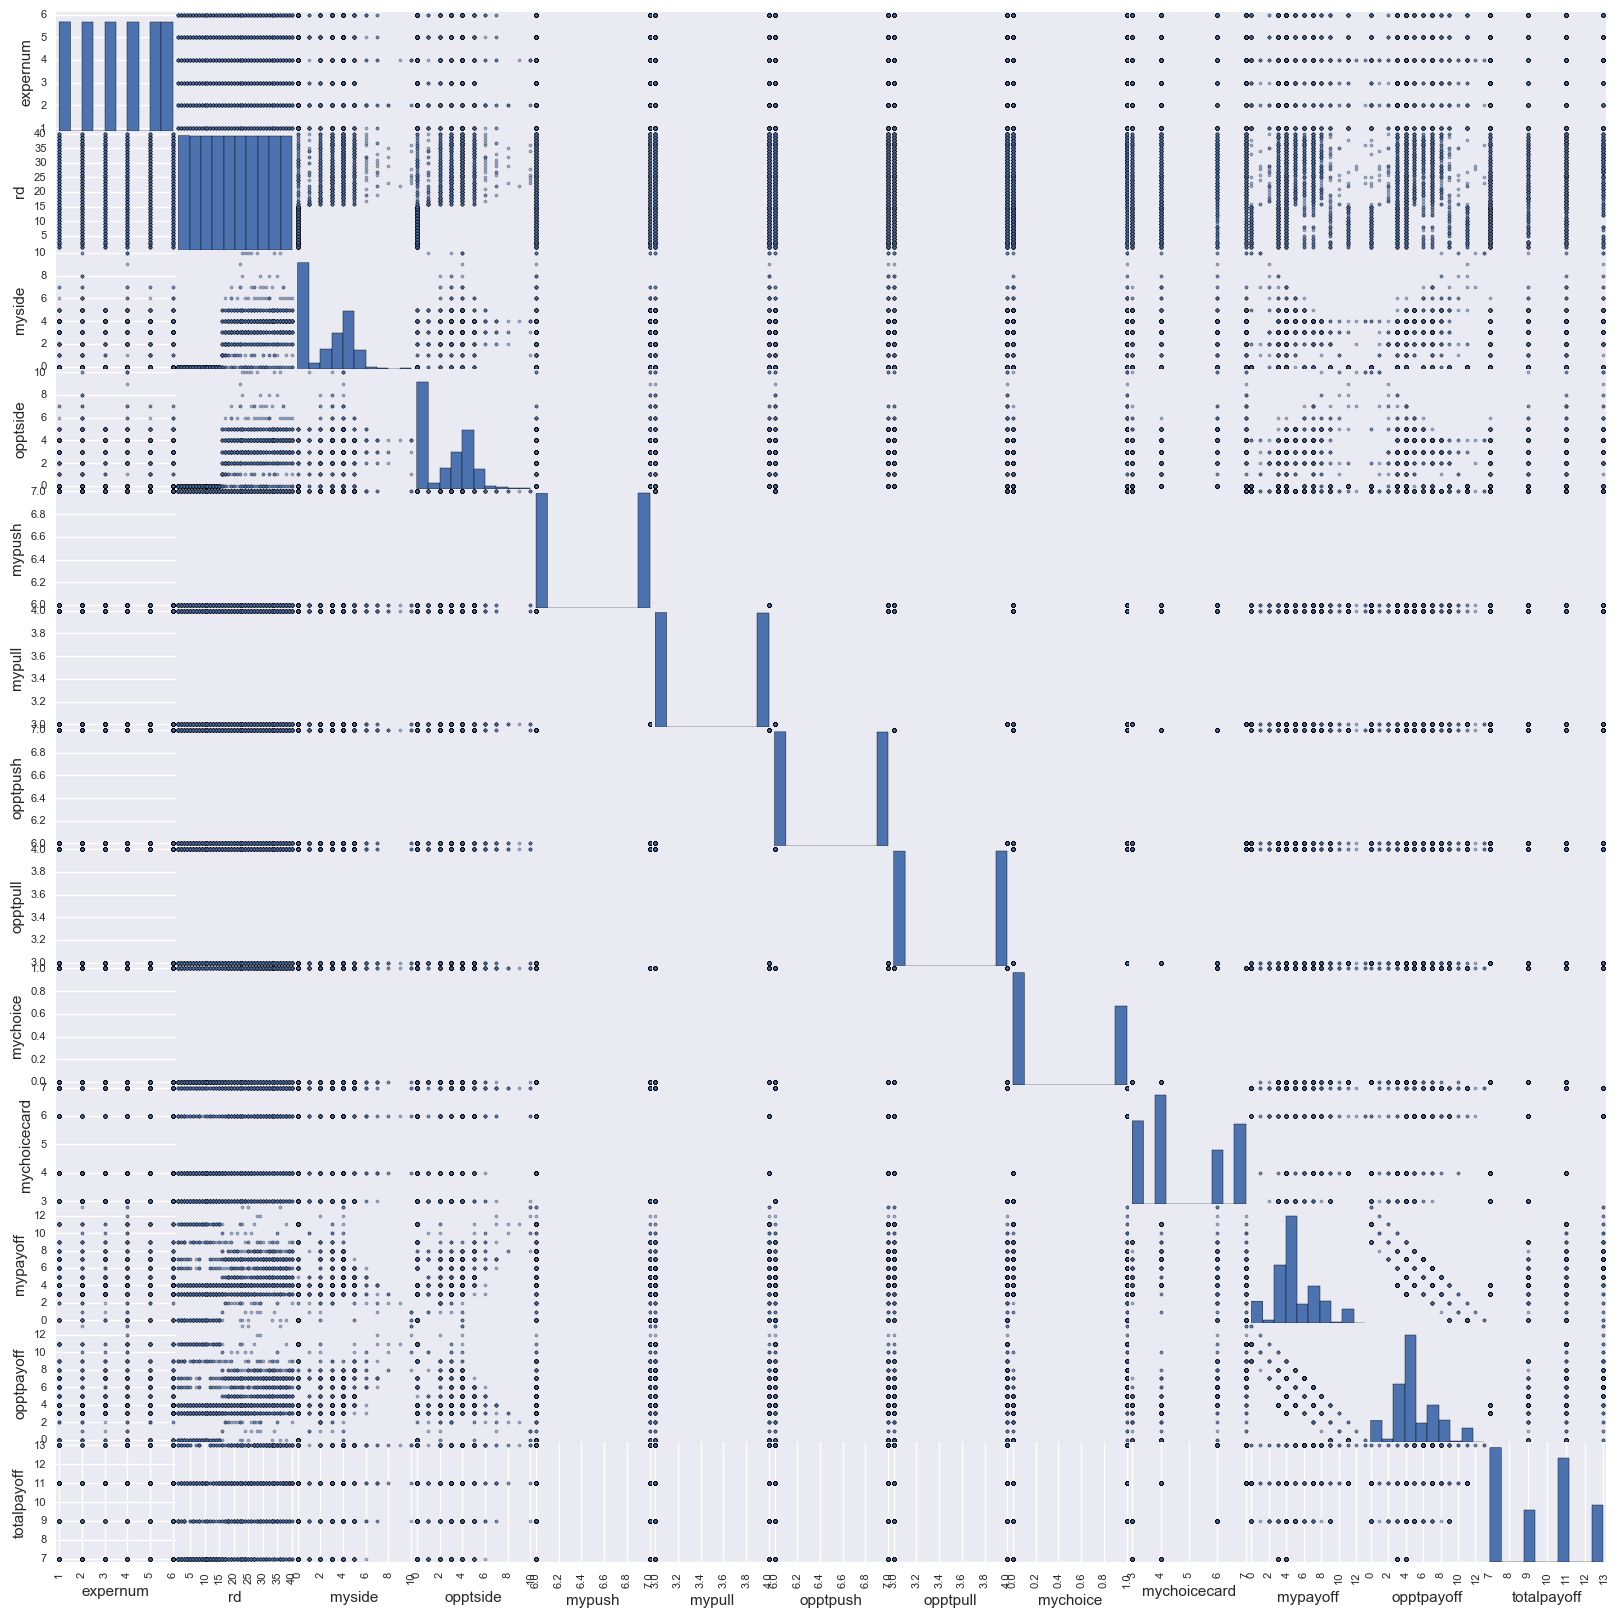

In [10]:
pd.scatter_matrix(ultimatum_df,figsize=(20,20));

- There seems to be some a relationship between the side payments and the payoffs between players.

### The first 15 rounds did not involve a side payment (paying the other person to accept your proposal), we will analyze this group first.

In [11]:
ultimatum_rd15_df = ultimatum_df[(ultimatum_df.rd <=15)]

ultimatum_pastrd15_df = ultimatum_df[(ultimatum_df.rd >15)]

In [12]:
ultimatum_rd15_df.head()

,expernum,rd,myside,opptside,mypush,mypull,opptpush,opptpull,mychoice,mychoicecard,mypayoff,opptpayoff,totalpayoff
0,1,1,0,0,6,4,7,3,0,4,11,0,11
1,1,1,0,0,7,3,6,4,1,7,0,11,11
2,1,1,0,0,6,4,7,3,0,4,4,3,7
3,1,1,0,0,7,3,6,4,0,3,3,4,7
4,1,1,0,0,7,3,6,4,1,7,6,7,13


In [13]:
ultimatum_rd15_df.describe()

,expernum,rd,myside,opptside,mypush,mypull,opptpush,opptpull,mychoice,mychoicecard,mypayoff,opptpayoff,totalpayoff
count,720.000000,720.000000,720.0,720.0,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,3.500000,8.000000,0.0,0.0,6.500000,3.500000,6.500000,3.500000,0.258333,4.341667,4.341667,4.341667,8.683333
std,1.709012,4.323497,0.0,0.0,0.500348,0.500348,0.500348,0.500348,0.438022,1.438566,3.363047,3.363047,2.072336
min,1.000000,1.000000,0.0,0.0,6.000000,3.000000,6.000000,3.000000,0.000000,3.000000,0.000000,0.000000,7.000000
25%,2.000000,4.000000,0.0,0.0,6.000000,3.000000,6.000000,3.000000,0.000000,3.000000,3.000000,3.000000,7.000000
50%,3.500000,8.000000,0.0,0.0,6.500000,3.500000,6.500000,3.500000,0.000000,4.000000,4.000000,4.000000,7.000000
75%,5.000000,12.000000,0.0,0.0,7.000000,4.000000,7.000000,4.000000,1.000000,6.000000,6.000000,6.000000,11.000000
max,6.000000,15.000000,0.0,0.0,7.000000,4.000000,7.000000,4.000000,1.000000,7.000000,11.000000,11.000000,13.000000


- Now drop, expernum

In [14]:
ultimatum_rd15_df = ultimatum_rd15_df.iloc[:,1:]
ultimatum_pastrd15_df = ultimatum_pastrd15_df.iloc[:,1:]
# drop for entire data set as well
ultimatum_df = ultimatum_df.iloc[:,1:]

In [15]:
ultimatum_rd15_df.head()

,rd,myside,opptside,mypush,mypull,opptpush,opptpull,mychoice,mychoicecard,mypayoff,opptpayoff,totalpayoff
0,1,0,0,6,4,7,3,0,4,11,0,11
1,1,0,0,7,3,6,4,1,7,0,11,11
2,1,0,0,6,4,7,3,0,4,4,3,7
3,1,0,0,7,3,6,4,0,3,3,4,7
4,1,0,0,7,3,6,4,1,7,6,7,13


In [16]:
ultimatum_rd15_df.columns

Index(['rd', 'myside', 'opptside', 'mypush', 'mypull', 'opptpush', 'opptpull',
       'mychoice', 'mychoicecard', 'mypayoff', 'opptpayoff', 'totalpayoff'],
      dtype='object')

## Threre are three groups  to test.
    - 1) Maximize your own payoff for rd 1-15
    - 2) Maximize your own payoff for rds past 15
    - 3) Maximize your own payoff for all rounds
    
> For the first 15 rounds, I will go through a manual grid search process to show how to find parameter finishing with a randomized grid search via Sklearn to confirm or reject the parameters I found. Then, for all other groups of data, I will look at the default values as well as the optimal grid searched values (in the interest of time).

## Data partions
- Manual gridsearch starts below. If you want to see the best models, skip to the final randomized gridsearch section.

In [17]:
##############Partioned data s et (rd 1-15) past rd 15)################
#Group one-maximize your payoff
ultimatum_rd15_df_mypayoff_X = np.array(ultimatum_rd15_df.iloc[:,:9])
ultimatum_rd15_df_mypayoff_y = np.array(ultimatum_rd15_df.iloc[:,9])


##scaled data for elastic net/glmnet rd -115
scale_1 = StandardScaler()
ultimatum_rd15_df_mypayoff_X_scaled =scale_1.fit_transform(ultimatum_rd15_df_mypayoff_X)



## past round 15
ultimatum_pastrd15_df_mypayoff_X = np.array(ultimatum_pastrd15_df.iloc[:,:9])
ultimatum_pastrd15_df_mypayoff_y = np.array(ultimatum_pastrd15_df.iloc[:,9])


## scale the data for elastic net/glmnet rd past 15
scale = StandardScaler()
ultimatum_pastrd15_df_mypayoff_X_scaled =scale.fit_transform(ultimatum_pastrd15_df_mypayoff_X)



#### Labels####
ultimatum_Xlabels = np.array(['rd', 'myside', 'opptside', 'mypush', 'mypull', 'opptpush', 'opptpull',\
       'mychoice', 'mychoicecard'])
ultimatum_ylabels = np.array(['mypayoff'])



############Total data set ##############

ultimatum_total_df_mypayoff_X = np.array(ultimatum_df.iloc[:,:9])
ultimatum_total_df_mypayoff_y = np.array(ultimatum_df.iloc[:,9])


##scaled data

scale_2 = StandardScaler()
ultimatum_total_df_mypayoff_X_scaled =scale_2.fit_transform(ultimatum_total_df_mypayoff_X)



/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [18]:
ultimatum_df.head()

,rd,myside,opptside,mypush,mypull,opptpush,opptpull,mychoice,mychoicecard,mypayoff,opptpayoff,totalpayoff
0,1,0,0,6,4,7,3,0,4,11,0,11
1,1,0,0,7,3,6,4,1,7,0,11,11
2,1,0,0,6,4,7,3,0,4,4,3,7
3,1,0,0,7,3,6,4,0,3,3,4,7
4,1,0,0,7,3,6,4,1,7,6,7,13


## Random Forest to predict your payoff for the first 15 rounds

In [19]:
#How much data do we have?
np.shape(ultimatum_rd15_df_mypayoff_X )

(720, 9)

In [20]:
#Not that much data...something to be aware of

In [21]:
regression_model_15_mypayoff= \
Model_Testing_Regression(ultimatum_rd15_df_mypayoff_X ,ultimatum_rd15_df_mypayoff_y,3,ultimatum_Xlabels,ultimatum_ylabels )

In [22]:
#default
regression_model_15_mypayoff.random_forest(100,'auto',None)

('RMSE Val:',
 2.9499584447794653,
 'RMSE Train:',
 2.7027367178641946,
 'RMSE TEST:',
 2.9129243501557718,
 [('rd', 0.31226086927433538),
  ('mychoicecard', 0.28215155127876174),
  ('mychoice', 0.25121082210555051),
  ('mypush', 0.04566115822982212),
  ('opptpush', 0.038342391569668871),
  ('mypull', 0.036949036458152056),
  ('opptpull', 0.033424171083709285),
  ('opptside', 0.0),
  ('myside', 0.0)])

- Plot out the progression of RF as we add more trees.

In [23]:
txt_v_rf,rmse_val_rf,txt_tr_rf,rmse_train_rf,txt_test_rf,rmse_test_rf,features_rf= zip(*[regression_model_15_mypayoff.random_forest(i,'auto',None) for i in range(1,700,25)])

Min RMSE for validation set: 2.8947209293815814, 3 folds cv
Min RMSE for train set: 2.6614081399010368, 3 folds cs
Min RMSE for test set: 2.866146876324777, 3 folds cv


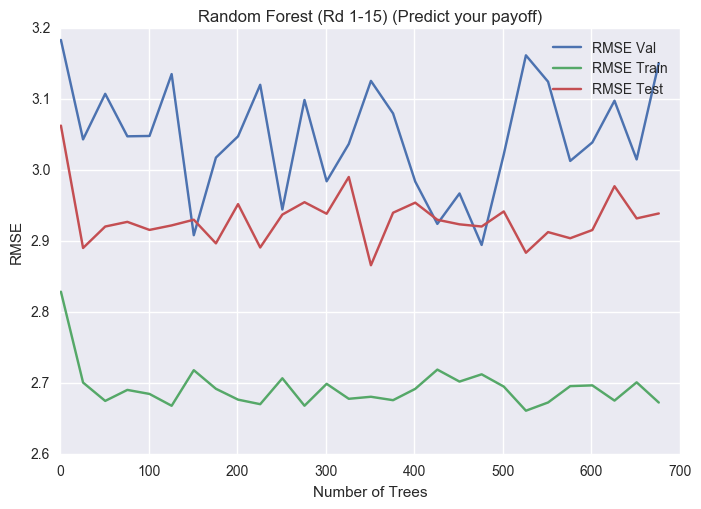

In [24]:
plt.plot([i for i in range(1,700,25)], rmse_val_rf,label='RMSE Val')
plt.plot([i for i in range(1,700,25)],rmse_train_rf , label='RMSE Train')
plt.plot([i for i in range(1,700,25)],rmse_test_rf, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_rf),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_rf),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_rf),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Random Forest (Rd 1-15) (Predict your payoff)')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE');

- Min cv test error at ~2.86 (units are dollars). Best parameters from min train error of ~2.58 at ~600 tree

# Final model below - Random Forest - Predict your payoff rd 1-15

In [25]:

regression_model_15_mypayoff.random_forest(600,'auto',None)

('RMSE Val:',
 3.1834364213492417,
 'RMSE Train:',
 2.6624806564104815,
 'RMSE TEST:',
 2.945429711789568,
 [('rd', 0.31021255895741473),
  ('mychoicecard', 0.29631014259711391),
  ('mychoice', 0.24580947552134721),
  ('opptpull', 0.038036780860873379),
  ('opptpush', 0.037444028454823565),
  ('mypull', 0.036351735165256353),
  ('mypush', 0.03583527844317113),
  ('opptside', 0.0),
  ('myside', 0.0)])

- It is interesting that round number is the most important feature. This means that as people learn how to play the game, the ability to predict your payoff increases.
- In addition, the number on your choice card is the second most important feature. This makes sense, the choice to push or pull is very important.

## Gradient Boosting to maximize your payoff rounds 1-15

In [26]:
#start with deafult
regression_model_15_mypayoff.gradient_boost(loss_type='ls',learning_rate_n=1.0,n_estimators_n=100,max_depth_n=3)

('RMSE Val:',
 2.9646688181060217,
 'RMSE Train:',
 2.7029172196166438,
 'RMSE TEST:',
 2.9004854919448184,
 [('rd', 0.58889596918612686),
  ('mychoicecard', 0.22812392365282405),
  ('mychoice', 0.096487308961334395),
  ('mypull', 0.028907018560970568),
  ('mypush', 0.022860940378509345),
  ('opptpull', 0.017378659288229407),
  ('opptpush', 0.017346179972005382),
  ('opptside', 0.0),
  ('myside', 0.0)])

In [27]:
txt_v_gb,rmse_val_gb,txt_tr_gb,rmse_train_gb,txt_test_gb,rmse_test_gb,features_gb=\
zip(*[regression_model_15_mypayoff.gradient_boost(loss_type='ls',learning_rate_n=1.0,n_estimators_n=i,max_depth_n=1)\
      for i in range(1,1000,25)])

Min RMSE for validation set: 2.782133492488865, 3 folds cv
Min RMSE for train set: 2.7855423170747406, 3 folds cs
Min RMSE for test set: 2.8765786860717424, 3 folds cv


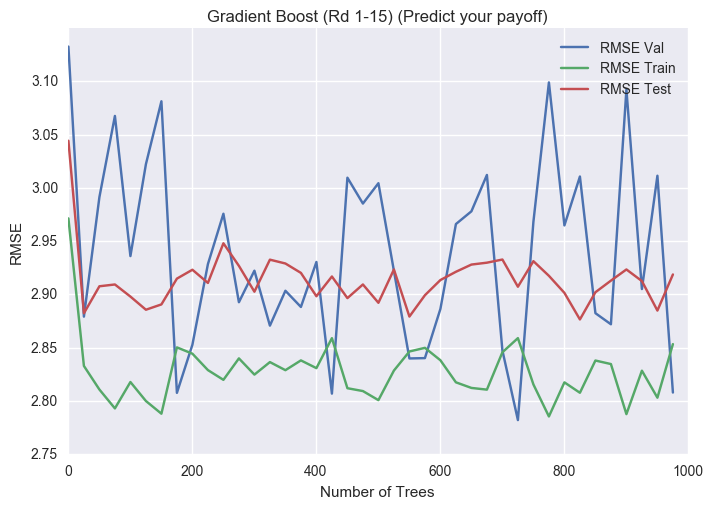

In [28]:
#plot the current model
plt.plot([i for i in range(1,1000,25)], rmse_val_gb,label='RMSE Val')
plt.plot([i for i in range(1,1000,25)],rmse_train_gb, label='RMSE Train')
plt.plot([i for i in range(1,1000,25)],rmse_test_gb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_gb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE');

- Min test RMSE of ~2.82 around with best parameters coming from the min train error of ~2.8 at 700 trees for the training data. Next, repeat this with huber loss. 

In [29]:
txt_v_gb,rmse_val_gb,txt_tr_gb,rmse_train_gb,txt_test_gb,rmse_test_gb,features_gb=\
zip(*[regression_model_15_mypayoff.gradient_boost(loss_type='huber',learning_rate_n=1.0,n_estimators_n=i,max_depth_n=1)\
      for i in range(1,1000,25)])

Min RMSE for validation set: 2.6625427726377, 3 folds cv
Min RMSE for train set: 2.813356585710677, 3 folds cs
Min RMSE for test set: 2.8697267987598742, 3 folds cv


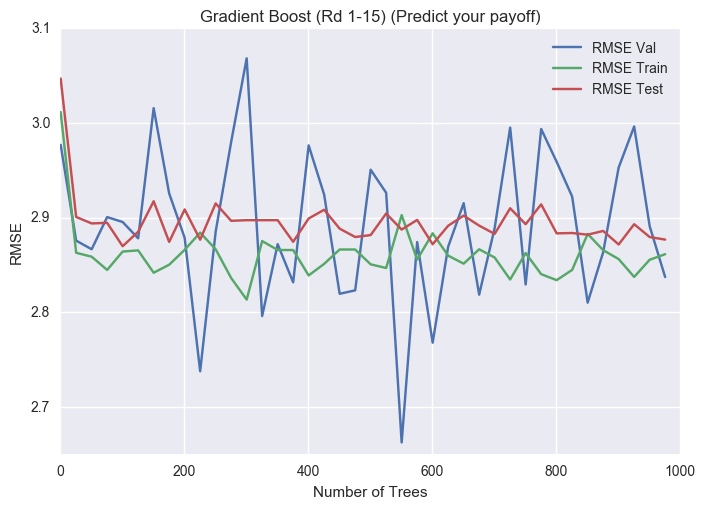

In [30]:
#plot the current model
plt.plot([i for i in range(1,1000,25)], rmse_val_gb,label='RMSE Val')
plt.plot([i for i in range(1,1000,25)],rmse_train_gb, label='RMSE Train')
plt.plot([i for i in range(1,1000,25)],rmse_test_gb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_gb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE');

- Min cv test RMSE about the same at ~2.84 for test. Best parameters from cv train RMSE comes from 225 tress and huber loss. Next, attempt to optimize the learning rate with 225 trees and huber loss.

In [31]:
txt_v_gb,rmse_val_gb,txt_tr_gb,rmse_train_gb,txt_test_gb,rmse_test_gb,features_gb=\
zip(*[regression_model_15_mypayoff.gradient_boost(loss_type='huber',learning_rate_n=i,n_estimators_n=225,max_depth_n=1)\
      for i in np.linspace(.00001,2,20)])

Min RMSE for validation set: 2.822275418249035, 3 folds cv
Min RMSE for train set: 2.7937483270448857, 3 folds cs
Min RMSE for test set: 2.8554694892855026, 3 folds cv


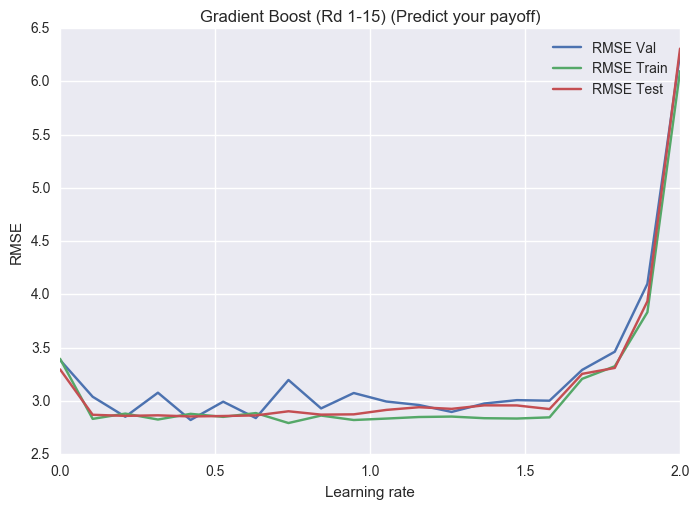

In [32]:
#plot the current model
plt.plot([i for i in np.linspace(.00001,2,20)], rmse_val_gb,label='RMSE Val')
plt.plot([i for i in np.linspace(.00001,2,20)],rmse_train_gb, label='RMSE Train')
plt.plot([i for i in np.linspace(.00001,2,20)],rmse_test_gb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_gb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Learning rate')
plt.ylabel('RMSE');

- Min cv test RMSE about the same at ~2.95 for training data. Best parameter for learning rate from cv train RMSE at 2.98. Next, max_depth with learning rate .9, 225 trees, and huber loss.

In [33]:
txt_v_gb,rmse_val_gb,txt_tr_gb,rmse_train_gb,txt_test_gb,rmse_test_gb,features_gb=\
zip(*[regression_model_15_mypayoff.gradient_boost(loss_type='huber',learning_rate_n=.9,n_estimators_n=225,max_depth_n=i)\
      for i in range(1,10)])

Min RMSE for validation set: 2.922000510212252, 3 folds cv
Min RMSE for train set: 2.7108825906313285, 3 folds cs
Min RMSE for test set: 2.8667512482563633, 3 folds cv


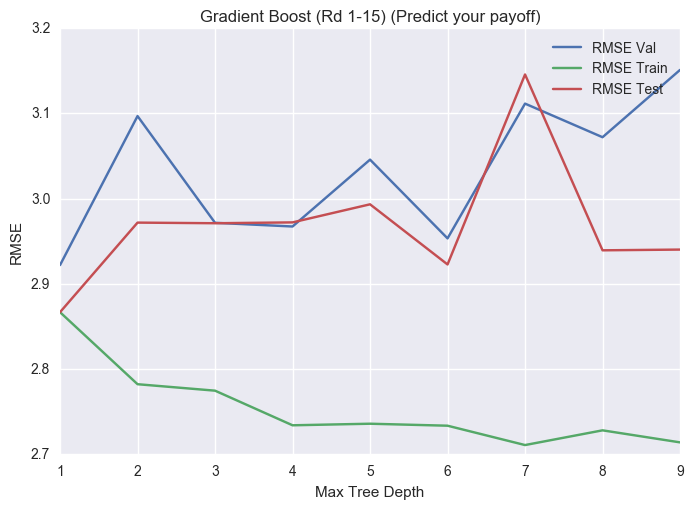

In [34]:
#plot the current model
plt.plot([i for i in range(1,10)], rmse_val_gb,label='RMSE Val')
plt.plot([i for i in range(1,10)],rmse_train_gb, label='RMSE Train')
plt.plot([i for i in range(1,10)],rmse_test_gb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_gb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Max Tree Depth')
plt.ylabel('RMSE');

- Slightly lower min cv RMSE for training data of 2.67~. Best parameters from cv validation with max depth=7.
- Build a final model with the parameters estimated from above.

### Final Model - Gradient Boosting - Predict your payoff


In [ ]:
#Best parameters
regression_model_15_mypayoff.gradient_boost(loss_type='huber',learning_rate_n=.9,n_estimators_n=225,max_depth_n=7)

- Min RMSE on test data for Gradient boosting ~3.02 vs min RMSE on test data for Random Forest of ~3.11. About the same.


# Test Extreme Gradient Boosting to maximizing your payoff for the first 15 rounds.

In [36]:
#Start with default parameters
regression_model_15_mypayoff.extreme_gradient_boost()

('RMSE Val:',
 2.9824509560389889,
 'RMSE Train:',
 2.7110926749204496,
 'RMSE TEST:',
 2.9474134539627754,
 [('rd', 0.61215216),
  ('mychoice', 0.15949009),
  ('mypush', 0.15361871),
  ('mychoicecard', 0.074739031),
  ('opptpull', 0.0),
  ('opptpush', 0.0),
  ('mypull', 0.0),
  ('opptside', 0.0),
  ('myside', 0.0)])

- First, start with n_estimators to optimize

In [37]:
txt_v_xgb,rmse_val_xgb,txt_tr_xgb,rmse_train_xgb,txt_test_xgb,rmse_test_xgb,features_xgb=\
zip(*[regression_model_15_mypayoff.extreme_gradient_boost(n_estimators_n=i) for i in range(1,500,25)])

Min RMSE for validation set: 2.9025078199735446, 3 folds cv
Min RMSE for train set: 2.6572147928673306, 3 folds cs
Min RMSE for test set: 2.8680398648207066, 3 folds cv


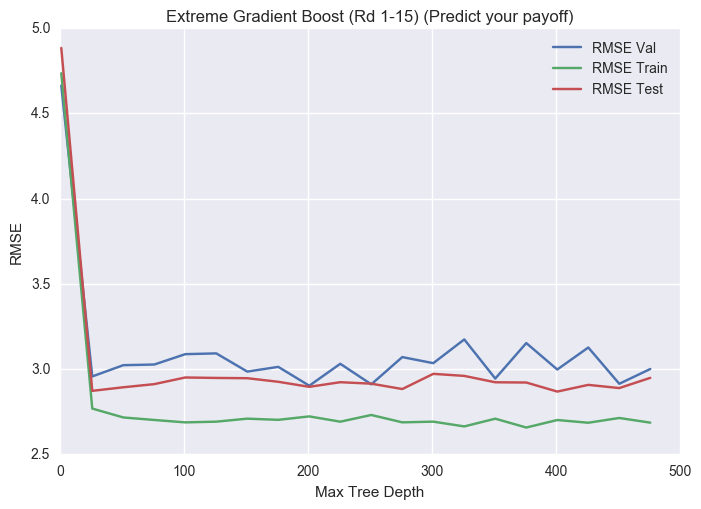

In [38]:
#plot the current model
plt.plot([i for i in range(1,500,25)], rmse_val_xgb,label='RMSE Val')
plt.plot([i for i in range(1,500,25)],rmse_train_xgb, label='RMSE Train')
plt.plot([i for i in range(1,500,25)],rmse_test_xgb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_xgb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_xgb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_xgb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Extreme Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Max Tree Depth')
plt.ylabel('RMSE');

- Min train RMSE at 250 trees. Next, optimize the max depth.

In [39]:
txt_v_xgb,rmse_val_xgb,txt_tr_xgb,rmse_train_xgb,txt_test_xgb,rmse_test_xgb,features_xgb=\
zip(*[regression_model_15_mypayoff.extreme_gradient_boost(n_estimators_n=250,max_depth_n=i) for i in range(1,50,2)])

Min RMSE for validation set: 2.942190933967241, 3 folds cv
Min RMSE for train set: 2.625865803909758, 3 folds cs
Min RMSE for test set: 2.865564777819873, 3 folds cv


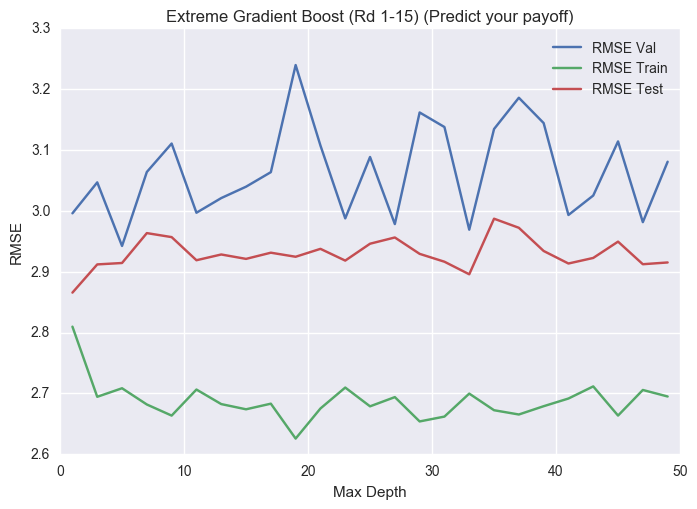

In [40]:
#plot the current model
plt.plot([i for i in range(1,50,2)], rmse_val_xgb,label='RMSE Val')
plt.plot([i for i in range(1,50,2)],rmse_train_xgb, label='RMSE Train')
plt.plot([i for i in range(1,50,2)],rmse_test_xgb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_xgb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_xgb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_xgb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Extreme Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Max Depth')
plt.ylabel('RMSE');

- Max depth at 12 trees for min train RMSE. Next, optimize the learning rate.

In [41]:
txt_v_xgb,rmse_val_xgb,txt_tr_xgb,rmse_train_xgb,txt_test_xgb,rmse_test_xgb,features_xgb=\
zip(*[regression_model_15_mypayoff.extreme_gradient_boost(n_estimators_n=250,max_depth_n=12,learning_rate_n=i) for i in np.linspace(.01,2.0,20)])

Min RMSE for validation set: 2.9011588924603537, 3 folds cv
Min RMSE for train set: 2.6467704329052246, 3 folds cs
Min RMSE for test set: 2.915629899025969, 3 folds cv


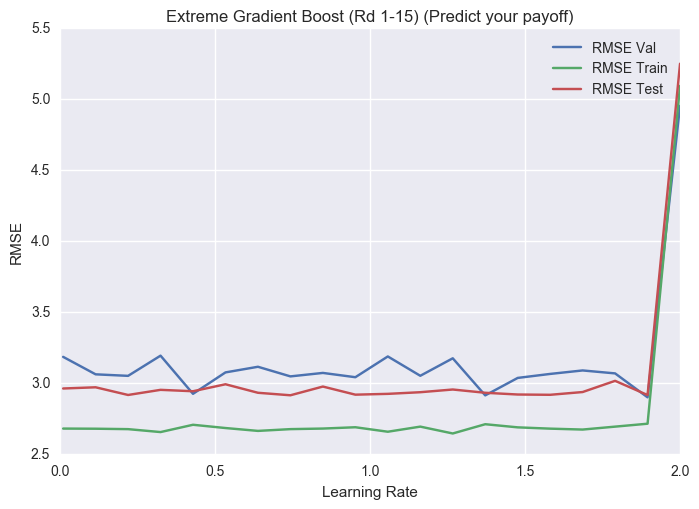

In [42]:
#plot the current model
plt.plot([i for i in np.linspace(.01,2.0,20)], rmse_val_xgb,label='RMSE Val')
plt.plot([i for i in np.linspace(.01,2.0,20)],rmse_train_xgb, label='RMSE Train')
plt.plot([i for i in np.linspace(.01,2.0,20)],rmse_test_xgb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_xgb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_xgb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_xgb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Extreme Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE');

- Min train error at learning rate of ~2.6 at .9. Final model presented below.

#### Final Model - Extreme Gradient Boosting - Predict your payoff (rd1-15)

In [43]:
regression_model_15_mypayoff.extreme_gradient_boost(n_estimators_n=250,max_depth_n=12,learning_rate_n=.9)

('RMSE Val:',
 3.0582333813349099,
 'RMSE Train:',
 2.673723351249945,
 'RMSE TEST:',
 2.9114187993839664,
 [('rd', 0.84171152),
  ('mypush', 0.13181564),
  ('mychoice', 0.02647282),
  ('mychoicecard', 0.0),
  ('opptpull', 0.0),
  ('opptpush', 0.0),
  ('mypull', 0.0),
  ('opptside', 0.0),
  ('myside', 0.0)])

# Elastic Net - Maximize your payoff - Rd 1-15
- Normalize the data. Note, the coefficients can only now be used to rank the importance, not to interpret what each coefficient means.

In [44]:
## look at a row to confirm it is scaled
ultimatum_rd15_df_mypayoff_X_scaled[0]

array([-1.62018517,  0.        ,  0.        , -1.        ,  1.        ,
        1.        , -1.        , -0.59018184, -0.23767018])

In [45]:
regression_model_15_mypayoff_scaled= Model_Testing_Regression(ultimatum_rd15_df_mypayoff_X_scaled,\
                                ultimatum_rd15_df_mypayoff_y,3,ultimatum_Xlabels,ultimatum_ylabels)

In [46]:
### Default model
regression_model_15_mypayoff_scaled.glm_net()

('RMSE Val:',
 2.884731202617314,
 'RMSE Train:',
 3.0053776110930586,
 'RMSE TEST:',
 3.0735586254676917,
 [('mychoice', 0.5619655767771411),
  ('mychoicecard', 0.15749088430787117),
  ('mypush', 0.10858032512745823),
  ('mypull', 0.10851752039635443),
  ('opptpull', 0.10846663507574962),
  ('opptpush', 0.10843224548070357),
  ('opptside', 0.0),
  ('myside', 0.0),
  ('rd', 0.0)])

- First, optimize the alpha or learning rate.

In [47]:
txt_v_en,rmse_val_en,txt_tr_en,rmse_train_en,txt_test_en,rmse_test_en,features_en=\
zip(*[regression_model_15_mypayoff_scaled.glm_net(alpha_n=i) for i in np.linspace(.01,.2,50)])

Min RMSE for validation set: 2.686723782827022, 3 folds cv
Min RMSE for train set: 2.77872154768955, 3 folds cs
Min RMSE for test set: 2.92696663690567, 3 folds cv


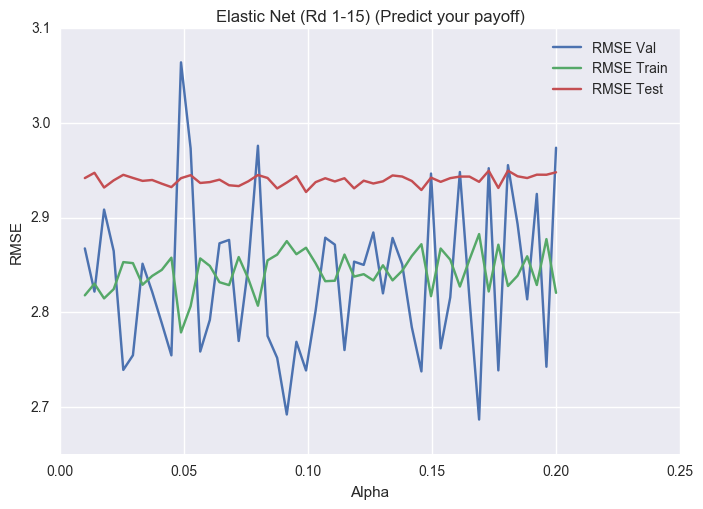

In [48]:
#plot the current model
plt.plot([i for i in np.linspace(.01,.2,50)], rmse_val_en,label='RMSE Val')
plt.plot([i for i in np.linspace(.01,.2,50)],rmse_train_en, label='RMSE Train')
plt.plot([i for i in np.linspace(.01,.2,50)],rmse_test_en, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_en),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_en),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_en),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Elastic Net (Rd 1-15) (Predict your payoff)')
plt.xlabel('Alpha')
plt.ylabel('RMSE');

- search for smaller alpha

In [49]:
txt_v_en,rmse_val_en,txt_tr_en,rmse_train_en,txt_test_en,rmse_test_en,features_en=\
zip(*[regression_model_15_mypayoff.glm_net(alpha_n=i) for i in np.linspace(.01,.2,50)])

Min RMSE for validation set: 2.721165463289888, 3 folds cv
Min RMSE for train set: 2.8294856236851746, 3 folds cs
Min RMSE for test set: 2.8130047042021675, 3 folds cv


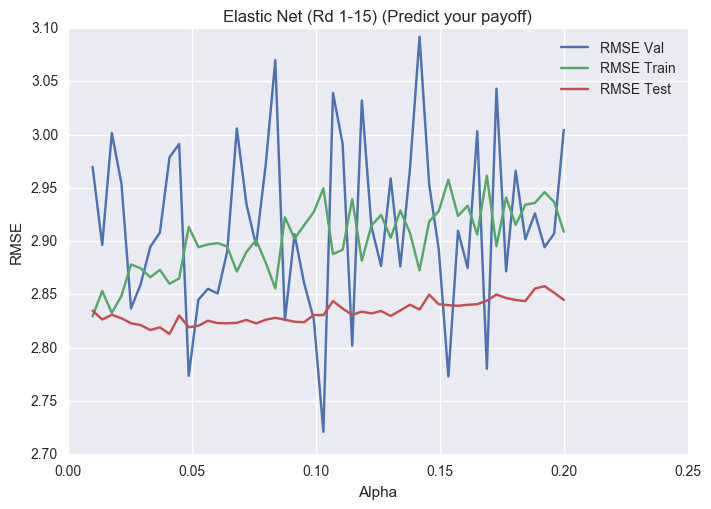

In [50]:
#plot the current model
plt.plot([i for i in np.linspace(.01,.2,50)], rmse_val_en,label='RMSE Val')
plt.plot([i for i in np.linspace(.01,.2,50)],rmse_train_en, label='RMSE Train')
plt.plot([i for i in np.linspace(.01,.2,50)],rmse_test_en, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_en),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_en),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_en),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Elastic Net (Rd 1-15) (Predict your payoff)')
plt.xlabel('Alpha')
plt.ylabel('RMSE');

- Min train cv at alpha of ~.04. Next, optimize lambda. The ratio between l1 and l2 penalty.

In [51]:
txt_v_en,rmse_val_en,txt_tr_en,rmse_train_en,txt_test_en,rmse_test_en,features_en=\
zip(*[regression_model_15_mypayoff_scaled.glm_net(alpha_n=.04,l1_ratio_n=i) for i in np.linspace(.001,.99,50)])

Min RMSE for validation set: 2.633984886656019, 3 folds cv
Min RMSE for train set: 2.7861802529437454, 3 folds cs
Min RMSE for test set: 2.9271597500524487, 3 folds cv


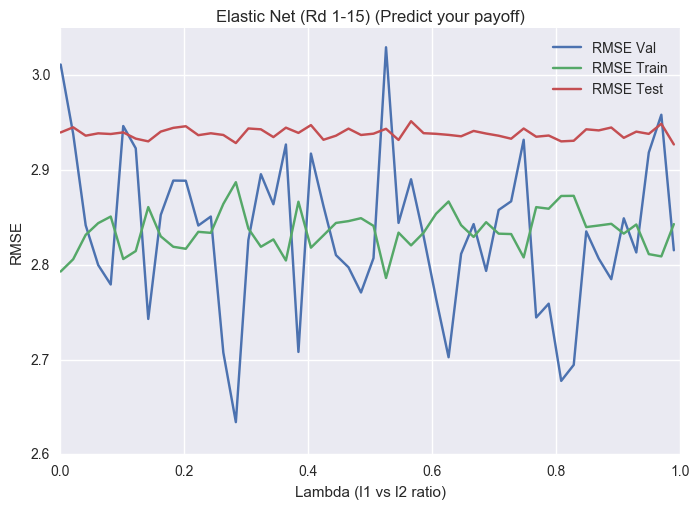

In [52]:
#plot the current model
plt.plot([i for i in np.linspace(.001,.99,50)], rmse_val_en,label='RMSE Val')
plt.plot([i for i in np.linspace(.001,.99,50)],rmse_train_en, label='RMSE Train')
plt.plot([i for i in np.linspace(.001,.99,50)],rmse_test_en, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_en),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_en),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_en),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Elastic Net (Rd 1-15) (Predict your payoff)')
plt.xlabel('Lambda (l1 vs l2 ratio)')
plt.ylabel('RMSE');

- Optimal lambda at ~.43 for min train RMSE. Print the final model.

### Final Model - Elastic net/GLMnet - Predict your payoff - Rd 1-15

In [53]:
regression_model_15_mypayoff_scaled.glm_net(alpha_n=.04,l1_ratio_n=.43)

('RMSE Val:',
 2.8884285614520007,
 'RMSE Train:',
 2.8195617814403477,
 'RMSE TEST:',
 2.9390295398867039,
 [('mychoice', 1.5274708200982561),
  ('opptpull', 0.2251085813859314),
  ('opptpush', 0.22164064071296707),
  ('mypush', 0.21929654466969314),
  ('mypull', 0.21575002168364943),
  ('mychoicecard', 0.16281194684796529),
  ('rd', 0.14481169809754313),
  ('opptside', 0.0),
  ('myside', 0.0)])

- Elastic net/GLMnet has a better test RMSE than RF, Gradient Boosting, and Extreme gradient boosting.
- It is interesting to note that the feature importances are ranked very differently in this regression model compared to the tree model (my choice card is the most important feature here). 
- About the same RMSE for the test set as the other two models (Gradient Boosting and Random Forest). The top two most important features are ranked the same way between these two models.

# Find the best features for rd 1-15 using randomized grid search (compare to manual grid search above).
- Data to use: X_train_rd_mypayoff, X_test_rd_mypayoff, y_train_rd_mypayoff, y_test_rd_mypayoff
- Scaled data for GLMnet: X_train_rd_mypayoff_scaled, X_test_rd_mypayoff_scaled, y_train_rd_mypayoff_notscaled, y_test_rd_mypayoff_notscaled\
- Max tree depth is ~10 (log2(samples))
- Learning rate .001 to 2.0
- N_estimators for trees should asymptote after 1,000
- Max features (how many features to consider for making a split)
- L1 ratio (how much L1 vs L2 penalty to give ). For GLM/Elastic net. 


In [54]:
np.shape(ultimatum_rd15_df)

(720, 12)

In [55]:
## max tree depth
np.log2(720)

9.4918530963296739

In [56]:
extreme_gradient_boost_parameters = {'max_depth':[i for i in range(1,10)], 'learning_rate':[i for i in np.linspace(.001,2.0,50)],
                                     'n_estimators':[i for i in range(50,1000,10)],
                                     'reg_alpha':[i for i in np.linspace(.001,5.0,50)],
                                     'reg_lambda':[i for i in np.linspace(.001,5.0,50)]
}
random_forest_parameters = {'n_estimators':[i for i in range(1,500)],'max_depth':[i for i in range(1,10)],\
                            'max_features':['auto','sqrt','log2']}
gradient_boost_parameters = {'loss':['ls', 'lad', 'huber', 'quantile'], 'learning_rate':[i for i in np.linspace(.001,2.0,50)],\
                            'n_estimators':[i for i in range(50,1000,10)],\
                            'max_depth':[i for i in range(1,10)],'subsample':[i for i in np.linspace(.001,1,30)],\
                              'alpha':[i for i in np.linspace(.001,.99,30)],'max_features':['auto','sqrt','log2']}
glm_net_parameters = {'alpha':[i for i in np.linspace(.001,2.99,30)],'l1_ratio':[i for i in np.linspace(.001,1.0,100)]  
}



#### Random Forest

In [57]:
#Random Forest - searhc through the training dataset
best_rf_rd15_model = regression_model_15_mypayoff.random_grid_search(model='random_forest',params_dict=random_forest_parameters)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.7min finished


In [58]:
# Best random forest
best_rf_rd15_mypayoff = best_rf_rd15_model


X_train_rd_mypayoff=regression_model_15_mypayoff.X_trainval ## make sure no data leakage, use same train test split in class
y_train_rd_mypayoff=regression_model_15_mypayoff.y_trainval
X_test_rd_mypayoff=regression_model_15_mypayoff.X_test ## make sure no data leakage, use same train test split in class
y_test_rd_mypayoff=regression_model_15_mypayoff.y_test

best_rf_rd15_mypayoff.fit( X_train_rd_mypayoff, y_train_rd_mypayoff)


best_rf_rd15_rmse =euclidean(y_test_rd_mypayoff,best_rf_rd15_mypayoff.predict(X_test_rd_mypayoff))/sqrt(len(y_test_rd_mypayoff))
print('Best RF RMSE :{}'.format(best_rf_rd15_rmse))
print()
best_rf_rd15_r2 =r2_score(y_test_rd_mypayoff,best_rf_rd15_mypayoff.predict(X_test_rd_mypayoff))
print('Best RF R^2 score :{:.2%}'.format(r2_score(y_test_rd_mypayoff,best_rf_rd15_mypayoff.predict(X_test_rd_mypayoff))))
print()
print([('Feature:',i,'Importance:',f)\
for f,i in zip(best_rf_rd15_mypayoff.feature_importances_[np.argsort(best_rf_rd15_mypayoff.feature_importances_)[::-1]],\
                                                    regression_model_15_mypayoff.x_labels[np.argsort(best_rf_rd15_mypayoff.feature_importances_)[::-1]])])

Best RF RMSE :2.848143151283482

Best RF R^2 score :22.62%

[('Feature:', 'mychoicecard', 'Importance:', 0.36623436445503171), ('Feature:', 'mychoice', 'Importance:', 0.28415242633734944), ('Feature:', 'mypush', 'Importance:', 0.087262561717959264), ('Feature:', 'opptpull', 'Importance:', 0.08040771443497069), ('Feature:', 'opptpush', 'Importance:', 0.078211591992183083), ('Feature:', 'mypull', 'Importance:', 0.077119184154320411), ('Feature:', 'rd', 'Importance:', 0.026612156908185476), ('Feature:', 'opptside', 'Importance:', 0.0), ('Feature:', 'myside', 'Importance:', 0.0)]


#### Gradient Boost

In [59]:
## search through the training data set for these rounds
best_gradientboost_rd15_model =regression_model_15_mypayoff.random_grid_search(model='gradient_boost',params_dict=gradient_boost_parameters)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.2min finished


In [60]:
#Best Gradient Boost model
best_gb_rd15_mypayoff = best_gradientboost_rd15_model

X_train_rd_mypayoff=regression_model_15_mypayoff.X_trainval ## make sure no data leakage, use same train test split in class
y_train_rd_mypayoff=regression_model_15_mypayoff.y_trainval
X_test_rd_mypayoff=regression_model_15_mypayoff.X_test ## make sure no data leakage, use same train test split in class
y_test_rd_mypayoff=regression_model_15_mypayoff.y_test
best_gb_rd15_mypayoff.fit(X_train_rd_mypayoff,y_train_rd_mypayoff)

best_gb_rd15_rmse = euclidean(y_test_rd_mypayoff,best_gb_rd15_mypayoff.predict(X_test_rd_mypayoff))/sqrt(len(y_test_rd_mypayoff))
print('Best GB RMSE :{}'.format(best_gb_rd15_rmse))
print()
best_gb_rd15_r2 = r2_score(y_test_rd_mypayoff,best_gb_rd15_mypayoff.predict(X_test_rd_mypayoff))
print('Best GB R^2 Score: {:.2%}'.format(r2_score(y_test_rd_mypayoff,best_gb_rd15_mypayoff.predict(X_test_rd_mypayoff))))
print()
print([('Feature:',i,'Importance:',f)\
for f,i in zip(best_gb_rd15_mypayoff.feature_importances_[np.argsort(best_gb_rd15_mypayoff.feature_importances_)[::-1]],\
                                                    regression_model_15_mypayoff.x_labels[np.argsort(best_gb_rd15_mypayoff.feature_importances_)[::-1]])])

Best GB RMSE :2.901697947162857

Best GB R^2 Score: 19.68%

[('Feature:', 'rd', 'Importance:', 0.30980392156862746), ('Feature:', 'mychoicecard', 'Importance:', 0.25294117647058822), ('Feature:', 'mychoice', 'Importance:', 0.13921568627450981), ('Feature:', 'opptpush', 'Importance:', 0.094117647058823528), ('Feature:', 'mypush', 'Importance:', 0.076470588235294124), ('Feature:', 'mypull', 'Importance:', 0.070588235294117646), ('Feature:', 'opptpull', 'Importance:', 0.054901960784313725), ('Feature:', 'opptside', 'Importance:', 0.0), ('Feature:', 'myside', 'Importance:', 0.0)]


#### Extreme Gradient Boost

In [61]:
# Search through the training dataset for these rounds
best_xgb_rd15_model =regression_model_15_mypayoff.random_grid_search(model='extreme_gradient_boost',params_dict=extreme_gradient_boost_parameters)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   13.0s finished


In [62]:
## Best Extreme Gradient Boosting
best_xgb_rd15_mypayoff=best_xgb_rd15_model 

X_train_rd_mypayoff=regression_model_15_mypayoff.X_trainval ## make sure no data leakage, use same train test split in class
y_train_rd_mypayoff=regression_model_15_mypayoff.y_trainval
X_test_rd_mypayoff=regression_model_15_mypayoff.X_test ## make sure no data leakage, use same train test split in class
y_test_rd_mypayoff=regression_model_15_mypayoff.y_test

best_xgb_rd15_mypayoff.fit( X_train_rd_mypayoff, y_train_rd_mypayoff)
best_xgb_rd15_rmse = euclidean(y_test_rd_mypayoff,best_xgb_rd15_mypayoff.predict(X_test_rd_mypayoff))/sqrt(len(y_test_rd_mypayoff))
print('Best XGB RMSE :{}'.format(best_xgb_rd15_rmse))
print()
best_xgb_rd15_r2 = r2_score(y_test_rd_mypayoff,best_xgb_rd15_mypayoff.predict(X_test_rd_mypayoff))
print('Best R^2 score for XGB : {:.2%}'.format(r2_score(y_test_rd_mypayoff,best_xgb_rd15_mypayoff.predict(X_test_rd_mypayoff))))
print()
print([('Feature:',i,'Importance:',f)\
for f,i in zip(best_xgb_rd15_mypayoff.feature_importances_[np.argsort(best_xgb_rd15_mypayoff.feature_importances_)[::-1]],\
        regression_model_15_mypayoff.x_labels[np.argsort(best_xgb_rd15_mypayoff.feature_importances_)[::-1]])])

Best XGB RMSE :2.855669206917954

Best R^2 score for XGB : 22.21%

[('Feature:', 'rd', 'Importance:', 0.33066666), ('Feature:', 'mychoice', 'Importance:', 0.32533333), ('Feature:', 'mychoicecard', 'Importance:', 0.292), ('Feature:', 'mypush', 'Importance:', 0.052000001), ('Feature:', 'opptpull', 'Importance:', 0.0), ('Feature:', 'opptpush', 'Importance:', 0.0), ('Feature:', 'mypull', 'Importance:', 0.0), ('Feature:', 'opptside', 'Importance:', 0.0), ('Feature:', 'myside', 'Importance:', 0.0)]


In [63]:
%autoreload 2

#### GLM/Elastic net

In [64]:
## find best GLM/Elastic net - searching through thetraining dataset (for these rounds)
best_glm_rd15_model = regression_model_15_mypayoff_scaled.random_grid_search(model='glm_net',params_dict=glm_net_parameters,iterations=1000);

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: Conv

In [ ]:
#Best GLMnet/Elastic net model
best_glmnet_rd15_mypayoff=best_glm_rd15_model 

X_train_rd_mypayoff_scaled= regression_model_15_mypayoff_scaled.X_trainval ## use same data partion as in the class
y_train_rd_mypayoff_notscaled= regression_model_15_mypayoff_scaled.y_trainval
X_test_rd_mypayoff_scaled= regression_model_15_mypayoff_scaled.X_test ## use same data partion as in the class
y_test_rd_mypayoff_notscaled= regression_model_15_mypayoff_scaled.y_test

best_glmnet_rd15_mypayoff.fit( X_train_rd_mypayoff_scaled, y_train_rd_mypayoff_notscaled)

best_glmnet_rd15_rmse = euclidean(y_test_rd_mypayoff_notscaled,best_glmnet_rd15_mypayoff.predict(X_test_rd_mypayoff_scaled))/\
                                     sqrt(len(y_test_rd_mypayoff_notscaled))
print('Best GLMnet RMSE : {}'.format(best_glmnet_rd15_rmse))
print()
best_glmnet_rd15_r2 =r2_score(y_test_rd_mypayoff_notscaled,best_glmnet_rd15_mypayoff.predict(X_test_rd_mypayoff_scaled))
print('Best R^2 for GLMnet/Elastic net :{:.2%}'.format(r2_score(y_test_rd_mypayoff_notscaled,best_glmnet_rd15_mypayoff.predict(X_test_rd_mypayoff_scaled))))
print()
print([('Feature:',i,'Importance:',abs(f))\
for f,i in zip(best_glmnet_rd15_mypayoff.coef_[np.argsort(abs(best_glmnet_rd15_mypayoff.coef_))[::-1]],\
                regression_model_15_mypayoff.x_labels[np.argsort(abs(best_glmnet_rd15_mypayoff.coef_))[::-1]])])

sorted_featres_glm_rd15 = [abs(i) for i in best_glmnet_rd15_mypayoff.coef_[np.argsort(abs(best_glmnet_rd15_mypayoff.coef_))[::-1]]]
features_weights_sorted_glm_rd15 = regression_model_15_mypayoff.x_labels[np.argsort(abs(best_glmnet_rd15_mypayoff.coef_))[::-1]]

## Best models for  Rd 1-15 to maximize your payoff
> Best model is hard to tell, but GLMnet/Elastic Net has the best RMSE ~(2.8) and R^2 ratio. Note, that the coefficients here are scaled so you can only rank by importance; you can not directly interpret these coefficients.
- RMSE: ~2.8
- For this model, top features are;
    - 1) mychoice: ~1.27
    - 2) mychoicecard: ~.231
    - 3) mypush: ~.216
- This means that ultimately, the best predictor of your payoff in the first 15 rounds using a GLMnet model is whether you pull or push (and the amount that you pull/push by).

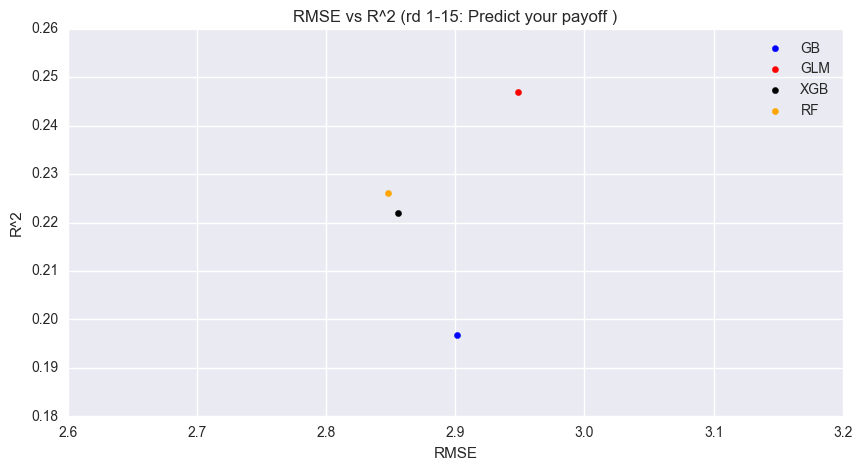

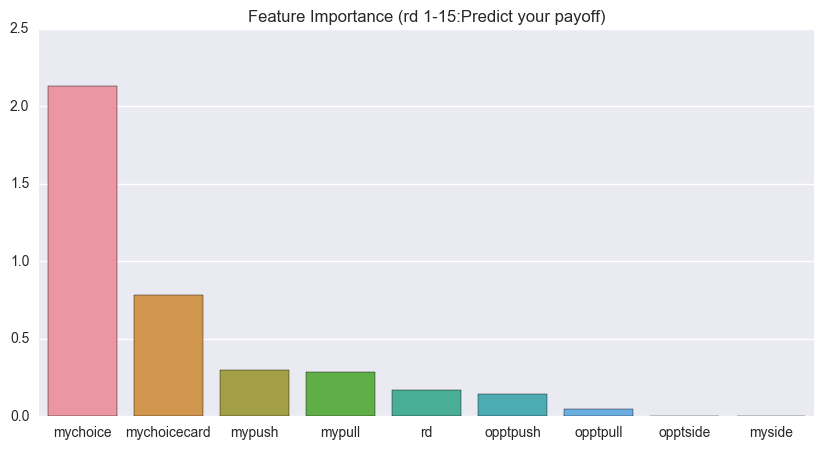

In [66]:
plt.figure(figsize=(10,5))
plt.scatter(best_gb_rd15_rmse,best_gb_rd15_r2,label='GB',color='b')
plt.scatter(best_glmnet_rd15_rmse,best_glmnet_rd15_r2,label='GLM',color='r')
plt.scatter(best_xgb_rd15_rmse,best_xgb_rd15_r2,label='XGB',color='black')
plt.scatter(best_rf_rd15_rmse,best_rf_rd15_r2,label='RF',color='orange')
plt.xlim(2.6,3.2)
plt.title('RMSE vs R^2 (rd 1-15: Predict your payoff )')
plt.xlabel('RMSE')
plt.ylabel('R^2')
plt.legend();
plt.figure(figsize=(10,5))
sns.barplot(x=features_weights_sorted_glm_rd15,y=sorted_featres_glm_rd15)
plt.title('Feature Importance (rd 1-15:Predict your payoff)')


# Maximize your payoff incorporating a side payment (RDs 15+)
- We will use the default parameters, and then gridsearch to find the best ones
- Data: X_train_pastrd15_mypayoff, X_test_pastrd15_mypayoff, y_train_pastrd15_mypayoff, y_test_pastrd15_mypayoff

In [72]:
np.shape(ultimatum_pastrd15_df_mypayoff_X)

(1200, 9)

In [73]:
### Almost twice the amount of data compared to the first 15 rounds.

### Random Forest - Predict your payoff - Past rd 15

In [74]:
regression_model_past15_mypayoff = Model_Testing_Regression(ultimatum_pastrd15_df_mypayoff_X,\
                                                            ultimatum_pastrd15_df_mypayoff_y,3,\
                                                           ultimatum_Xlabels ,\
                                                           ultimatum_ylabels)

In [75]:
#Default Random Forest
regression_model_past15_mypayoff.random_forest()

('RMSE Val:',
 1.4257986341603697,
 'RMSE Train:',
 0.75706185310933527,
 'RMSE TEST:',
 1.6343601057489014,
 [('opptside', 0.32354393669674886),
  ('rd', 0.23656901425465948),
  ('myside', 0.21913600130798827),
  ('opptpush', 0.052664433721553827),
  ('opptpull', 0.040735667135777802),
  ('mypull', 0.036315400705409201),
  ('mychoicecard', 0.035433504438806926),
  ('mychoice', 0.031588685318100253),
  ('mypush', 0.024013356420955353)])

- Much lower RMSE than the previous 15 rounds. 

### Gradient Boosting - Predict your payoff - Past rd 15

In [76]:
# Default Gradient Boost
regression_model_past15_mypayoff.gradient_boost()

('RMSE Val:',
 1.3458403260282326,
 'RMSE Train:',
 1.1996446264028944,
 'RMSE TEST:',
 1.488309287826983,
 [('opptside', 0.29410327607271408),
  ('rd', 0.24903835426111395),
  ('myside', 0.24285829177585697),
  ('mychoicecard', 0.090165380896905997),
  ('mychoice', 0.04514005297872644),
  ('opptpush', 0.022699040488570358),
  ('mypull', 0.021888639977408753),
  ('opptpull', 0.01918019364428868),
  ('mypush', 0.014926769904414735)])

- Also, much lower RMSE (and lower then RF)>

### Extreme Gradient Boosting - Predict your payoff - Past rd 15

In [77]:
regression_model_past15_mypayoff.extreme_gradient_boost()

('RMSE Val:',
 1.3560206137367068,
 'RMSE Train:',
 1.1927194596447797,
 'RMSE TEST:',
 1.4934200543148515,
 [('rd', 0.30385894),
  ('opptside', 0.27735004),
  ('myside', 0.22554575),
  ('mychoice', 0.093746997),
  ('mypush', 0.055724561),
  ('mychoicecard', 0.043773707),
  ('opptpull', 0.0),
  ('opptpush', 0.0),
  ('mypull', 0.0)])

- Slightly better performance from regular gradient boosting.

### GLMnet (Elastic Net) - Predict your payoff - Past rd 15
- Need to use scaled data here
- Data: X_train_pastrd15_mypayoff_scaled, X_test_pastrd15_mypayoff_scaled, y_train_pastrd15_mypayoff_notscaled,
y_test_pastrd15_mypayoff_notscaled
- Data :ultimatum_pastrd15_df_mypayoff_X_scaled 

In [78]:
regression_model_past15_mypayoff_scaled = Model_Testing_Regression(ultimatum_pastrd15_df_mypayoff_X_scaled,\
                                                            ultimatum_pastrd15_df_mypayoff_y,3,\
                                                           ultimatum_Xlabels ,\
                                                           ultimatum_ylabels)

In [79]:
#Default GLM net
regression_model_past15_mypayoff_scaled.glm_net()

('RMSE Val:',
 1.840274839338842,
 'RMSE Train:',
 1.8481809987704052,
 'RMSE TEST:',
 1.7710214158493394,
 [('opptside', 0.081779941113374263),
  ('mypull', 0.048281050877601844),
  ('mypush', 0.048274125861936586),
  ('opptpush', 0.048272600351187744),
  ('opptpull', 0.048265631931631046),
  ('mychoicecard', 0.0),
  ('mychoice', 0.0),
  ('myside', 0.0),
  ('rd', 0.0)])

- Extreme Gradient boosting performs the best from the default parameters. Next,gridsearch over the space.

## Random gridsearch to maximize your payoff, past rd 15

- Max tree depth is ~10 (log2(samples))
- Learning rate .001 to 2.0
- N_estimators for trees should asymptote after 1,000
- Max features (how many features to consider for making a split)
- L1 ratio (how much L1 vs L2 penalty to give ). For GLM/Elastic net. 

In [80]:
extreme_gradient_boost_parameters = {'max_depth':[i for i in range(1,10)], 'learning_rate':[i for i in np.linspace(.001,2.0,50)],
                                     'n_estimators':[i for i in range(50,1000,10)],
                                     'reg_alpha':[i for i in np.linspace(.001,5.0,50)],
                                     'reg_lambda':[i for i in np.linspace(.001,5.0,50)]
}
random_forest_parameters = {'n_estimators':[i for i in range(1,500)],'max_depth':[i for i in range(1,10)],\
                            'max_features':['auto','sqrt','log2']}
gradient_boost_parameters = {'loss':['ls', 'lad', 'huber', 'quantile'], 'learning_rate':[i for i in np.linspace(.001,2.0,50)],\
                            'n_estimators':[i for i in range(50,1000,10)],\
                            'max_depth':[i for i in range(1,10)],'subsample':[i for i in np.linspace(.001,1,30)],\
                              'alpha':[i for i in np.linspace(.001,.99,30)],'max_features':['auto','sqrt','log2']}
glm_net_parameters = {'alpha':[i for i in np.linspace(.001,2.99,30)],'l1_ratio':[i for i in np.linspace(.001,1.0,100)]  
}



In [81]:
#Random Forest - train on thetraining  data set

best_rf_pastrd15_model = regression_model_past15_mypayoff.random_grid_search(model='random_forest',params_dict=random_forest_parameters)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.8min finished


#### Random Forest

In [82]:
#Best Random Forest Model
best_rf_pastrd15_mypayoff = best_rf_pastrd15_model


## use the same data partion as in the class
X_train_pastrd15_mypayoff = regression_model_past15_mypayoff.X_trainval
y_train_pastrd15_mypayoff = regression_model_past15_mypayoff.y_trainval
X_test_pastrd15_mypayoff = regression_model_past15_mypayoff.X_test
y_test_pastrd15_mypayoff = regression_model_past15_mypayoff.y_test

best_rf_pastrd15_mypayoff.fit( X_train_pastrd15_mypayoff, y_train_pastrd15_mypayoff)
### train test split from the initial data partion
best_rf_pastrd15_rmse=euclidean(y_test_pastrd15_mypayoff,best_rf_pastrd15_mypayoff.predict(X_test_pastrd15_mypayoff))/sqrt(len(y_test_pastrd15_mypayoff))
print('Best RF RMSE :{}'.format(best_rf_pastrd15_rmse))
print()
best_rf_pastrd15_r2 = r2_score(y_test_pastrd15_mypayoff,best_rf_pastrd15_mypayoff.predict(X_test_pastrd15_mypayoff))
print('Best RF R^2 :{:.2%}'.format(r2_score(y_test_pastrd15_mypayoff,best_rf_pastrd15_mypayoff.predict(X_test_pastrd15_mypayoff))))
print()
print([('Feature:',i,'Importance:',f)\
for f,i in zip(best_rf_pastrd15_mypayoff.feature_importances_[np.argsort(best_rf_pastrd15_mypayoff.feature_importances_)[::-1]],\
    regression_model_past15_mypayoff.x_labels[np.argsort(best_rf_pastrd15_mypayoff.feature_importances_)[::-1]])])

Best RF RMSE :1.5184689185148645

Best RF R^2 :41.22%

[('Feature:', 'opptside', 'Importance:', 0.35479434329520065), ('Feature:', 'myside', 'Importance:', 0.2616659210538268), ('Feature:', 'rd', 'Importance:', 0.097149912710949707), ('Feature:', 'mypush', 'Importance:', 0.065756286010468457), ('Feature:', 'opptpush', 'Importance:', 0.055552366716116637), ('Feature:', 'mypull', 'Importance:', 0.054973880911936092), ('Feature:', 'opptpull', 'Importance:', 0.046032959851020093), ('Feature:', 'mychoicecard', 'Importance:', 0.035618314467860492), ('Feature:', 'mychoice', 'Importance:', 0.028456014982621115)]


#### Gradient Boosting

In [83]:
#Gradient Boosting - looking through the training data set

best_gb_pastrd15_model = regression_model_past15_mypayoff.random_grid_search(model='gradient_boost',params_dict=gradient_boost_parameters)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.2min finished


In [84]:
# Best Gradient Boosting Model


best_gb_pastrd15_mypayoff = best_gb_pastrd15_model
## use the same data partion as in the class
X_train_pastrd15_mypayoff = regression_model_past15_mypayoff.X_trainval
y_train_pastrd15_mypayoff = regression_model_past15_mypayoff.y_trainval
X_test_pastrd15_mypayoff = regression_model_past15_mypayoff.X_test
y_test_pastrd15_mypayoff = regression_model_past15_mypayoff.y_test

best_gb_pastrd15_model.fit(X_train_pastrd15_mypayoff,y_train_pastrd15_mypayoff)
    

best_gb_pastrd15_rmse=euclidean(y_test_pastrd15_mypayoff,best_gb_pastrd15_mypayoff.predict(X_test_pastrd15_mypayoff))/sqrt(len(y_test_pastrd15_mypayoff))
print('Best GB RMSE :{}'.format(best_gb_pastrd15_rmse))
print()
best_gb_pastrd15_r2 = r2_score(y_test_pastrd15_mypayoff,best_gb_pastrd15_mypayoff.predict(X_test_pastrd15_mypayoff))
print('Best GB R^2:{:.2%}'.format(r2_score(y_test_pastrd15_mypayoff,best_gb_pastrd15_mypayoff.predict(X_test_pastrd15_mypayoff))))
print()
print([('Feature:',i,'Importance:',f)\
for f,i in zip(best_gb_pastrd15_mypayoff.feature_importances_[np.argsort(best_gb_pastrd15_mypayoff.feature_importances_)[::-1]],\
    regression_model_past15_mypayoff.x_labels[np.argsort(best_gb_pastrd15_mypayoff.feature_importances_)[::-1]])])


sorted_featres_gb_pastrd15 = best_gb_pastrd15_mypayoff.feature_importances_[np.argsort(best_gb_pastrd15_mypayoff.feature_importances_)[::-1]]
features_weights_sorted_gb_pastrd15 = regression_model_past15_mypayoff.x_labels[np.argsort(best_gb_pastrd15_mypayoff.feature_importances_)[::-1]]

Best GB RMSE :1.5773157301043854

Best GB R^2:36.58%

[('Feature:', 'rd', 'Importance:', 0.2340909090909091), ('Feature:', 'opptside', 'Importance:', 0.22159090909090909), ('Feature:', 'myside', 'Importance:', 0.16818181818181818), ('Feature:', 'mychoicecard', 'Importance:', 0.14204545454545456), ('Feature:', 'mychoice', 'Importance:', 0.076136363636363641), ('Feature:', 'opptpush', 'Importance:', 0.060227272727272727), ('Feature:', 'mypull', 'Importance:', 0.045454545454545456), ('Feature:', 'opptpull', 'Importance:', 0.026136363636363635), ('Feature:', 'mypush', 'Importance:', 0.026136363636363635)]


#### Extreme Gradient Boosting

In [85]:
#- looking through the traiing data set# Extreme Gradient Boosting


best_xgb_pastrd15_model = regression_model_past15_mypayoff.random_grid_search(model='extreme_gradient_boost',params_dict=extreme_gradient_boost_parameters)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   29.0s finished


In [86]:
# Best Extreme  Gradient Boosting Model 


best_xgb_pastrd15_mypayoff = best_xgb_pastrd15_model

## use the same data partion as in the class
X_train_pastrd15_mypayoff = regression_model_past15_mypayoff.X_trainval
y_train_pastrd15_mypayoff = regression_model_past15_mypayoff.y_trainval
X_test_pastrd15_mypayoff = regression_model_past15_mypayoff.X_test
y_test_pastrd15_mypayoff = regression_model_past15_mypayoff.y_test


best_xgb_pastrd15_mypayoff.fit( X_train_pastrd15_mypayoff, y_train_pastrd15_mypayoff)
### train test split from the initial data partion
best_xgb_pastrd15_rmse=euclidean(y_test_pastrd15_mypayoff,best_xgb_pastrd15_mypayoff.predict(X_test_pastrd15_mypayoff))/sqrt(len(y_test_pastrd15_mypayoff))
print('Best XGB RMSE :{}'.format(best_xgb_pastrd15_rmse))
print()
best_xgb_pastrd15_r2 = r2_score(y_test_pastrd15_mypayoff,best_xgb_pastrd15_mypayoff.predict(X_test_pastrd15_mypayoff))
print('Best XGB R^2 score: {:.2%}'.format(r2_score(y_test_pastrd15_mypayoff,best_xgb_pastrd15_mypayoff.predict(X_test_pastrd15_mypayoff))))
print()
print([('Feature:',i,'Importance:',f)\
for f,i in zip(best_xgb_pastrd15_mypayoff.feature_importances_[np.argsort(best_xgb_pastrd15_mypayoff.feature_importances_)[::-1]],\
    regression_model_past15_mypayoff.x_labels[np.argsort(best_xgb_pastrd15_mypayoff.feature_importances_)[::-1]])])


sorted_featres_xgb_pastrd15 = best_xgb_pastrd15_mypayoff.feature_importances_[np.argsort(best_xgb_pastrd15_mypayoff.feature_importances_)[::-1]]
features_weights_sorted_xgb_pastrd15 = regression_model_past15_mypayoff.x_labels[np.argsort(best_xgb_pastrd15_mypayoff.feature_importances_)[::-1]]

Best XGB RMSE :1.5164428881586005

Best XGB R^2 score: 41.38%

[('Feature:', 'opptside', 'Importance:', 0.34169278), ('Feature:', 'rd', 'Importance:', 0.28840125), ('Feature:', 'myside', 'Importance:', 0.17868339), ('Feature:', 'mychoice', 'Importance:', 0.084639497), ('Feature:', 'mychoicecard', 'Importance:', 0.078369908), ('Feature:', 'mypush', 'Importance:', 0.028213166), ('Feature:', 'opptpull', 'Importance:', 0.0), ('Feature:', 'opptpush', 'Importance:', 0.0), ('Feature:', 'mypull', 'Importance:', 0.0)]


#### GLM/Elastic Net

In [87]:
##glm net/ Elastic net - looking through the training data set. Convergence warning due to a small alpha

best_glm_pastrd15_model = regression_model_past15_mypayoff_scaled.random_grid_search(model='glm_net', params_dict=glm_net_parameters, iterations=3000)

Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: Conv

In [88]:
# Best elastic net/glm net

best_glmnet_pastrd15_mypayoff = best_glm_pastrd15_model

## use the same data partion as in the class
X_train_pastrd15_mypayoff_scaled = regression_model_past15_mypayoff_scaled.X_trainval
y_train_pastrd15_mypayoff_notscaled = regression_model_past15_mypayoff_scaled.y_trainval
X_test_pastrd15_mypayoff_scaled = regression_model_past15_mypayoff_scaled.X_test
y_test_pastrd15_mypayoff_notscaled = regression_model_past15_mypayoff_scaled.y_test

best_glmnet_pastrd15_mypayoff.fit( X_train_pastrd15_mypayoff_scaled, y_train_pastrd15_mypayoff_notscaled)
### train test split from the initial data partion
best_glmnet_pastrd15_rmse=euclidean(y_test_pastrd15_mypayoff_notscaled,\
best_glmnet_pastrd15_mypayoff.predict(X_test_pastrd15_mypayoff_scaled))/sqrt(len(y_test_pastrd15_mypayoff_notscaled))
print('Best GLMnet/Elastic Net RMSE :{}'.format(best_glmnet_pastrd15_rmse))
print()
best_glmnet_pastrd15_r2=r2_score(y_test_pastrd15_mypayoff_notscaled,\
best_glmnet_pastrd15_mypayoff.predict(X_test_pastrd15_mypayoff_scaled))
print('Best R^2 score {:.2%}'.format(r2_score(y_test_pastrd15_mypayoff_notscaled,\
best_glmnet_pastrd15_mypayoff.predict(X_test_pastrd15_mypayoff_scaled))))
print()
print([('Feature:',i,'Importance:',abs(f))\
for f,i in zip(best_glmnet_pastrd15_mypayoff.coef_[np.argsort(abs(best_glmnet_pastrd15_mypayoff.coef_))[::-1]],\
    regression_model_past15_mypayoff.x_labels[np.argsort(abs(best_glmnet_pastrd15_mypayoff.coef_))[::-1]])])

Best GLMnet/Elastic Net RMSE :1.5724348445935579

Best R^2 score 26.69%

[('Feature:', 'mychoice', 'Importance:', 0.71164426410286463), ('Feature:', 'mypush', 'Importance:', 0.71083336485671156), ('Feature:', 'opptside', 'Importance:', 0.65961990862941311), ('Feature:', 'mychoicecard', 'Importance:', 0.59459249286950677), ('Feature:', 'rd', 'Importance:', 0.11231828180164577), ('Feature:', 'myside', 'Importance:', 0.028217611738905232), ('Feature:', 'mypull', 'Importance:', 4.3576442850403928e-16), ('Feature:', 'opptpull', 'Importance:', 1.3877848041529915e-17), ('Feature:', 'opptpush', 'Importance:', 1.0177088563788604e-17)]


# Results - Predict your payoff- Past rd15

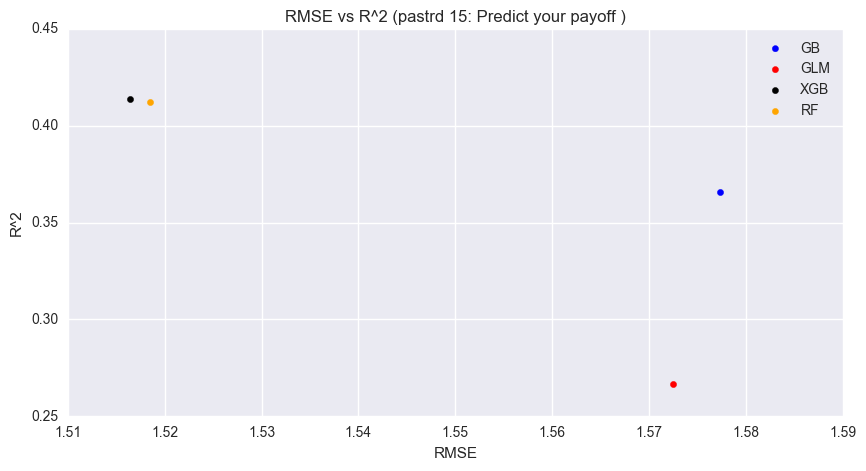

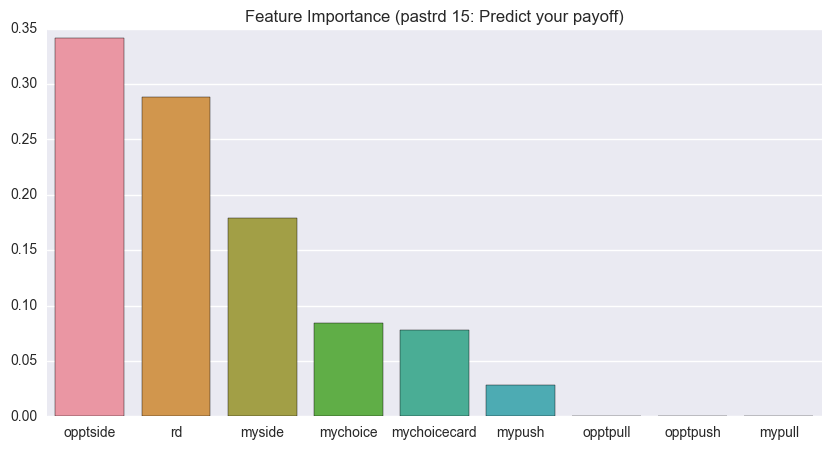

In [89]:
plt.figure(figsize=(10,5))
plt.scatter(best_gb_pastrd15_rmse,best_gb_pastrd15_r2,label='GB',color='b')
plt.scatter(best_glmnet_pastrd15_rmse,best_glmnet_pastrd15_r2,label='GLM',color='r')
plt.scatter(best_xgb_pastrd15_rmse,best_xgb_pastrd15_r2,label='XGB',color='black')
plt.scatter(best_rf_pastrd15_rmse,best_rf_pastrd15_r2,label='RF',color='orange')
plt.title('RMSE vs R^2 (pastrd 15: Predict your payoff )')
plt.xlabel('RMSE')
plt.ylabel('R^2')
plt.legend();


plt.figure(figsize=(10,5))
sns.barplot(x=features_weights_sorted_xgb_pastrd15,y=sorted_featres_xgb_pastrd15)
plt.title('Feature Importance (pastrd 15: Predict your payoff)')

### Best Model
-XGB is the best model in terms of both RMSE and R^2. 

- Metrics
    - Best XGB RMSE :~1.45
    - Best XGB R^2 score: ~43
    - [('Feature:', 'opptside', 'Importance:', 0.2972973), ('Feature:', 'myside', 'Importance:', 0.23573573), ('Feature:', 'rd', 'Importance:', 0.21921922), ('Feature:', 'mychoice', 'Importance:', 0.12687688), ('Feature:', 'mypush', 'Importance:', 0.063063063), ('Feature:', 'mychoicecard', 'Importance:', 0.057807807), ('Feature:', 'opptpull', 'Importance:', 0.0), ('Feature:', 'opptpush', 'Importance:', 0.0), ('Feature:', 'mypull', 'Importance:', 0.0)]

    
> The top three features are.
    - RD (which round is it)
    - Opptside (how much your opponent offers you for your to push)
    - My side (How much you are willing to offer to your opponent so that they push)
    
> This is in contrast to the first 15 rounds where the most important features where.
    - 1) mychoice: ~1.27
    - 2) mychoicecard: ~.231
    - 3) opptpush: ~.216
    
**This means that, for rds past 15, to maximize your payments, you should wait until people learn how to play the game and then offer them something to have them push to you**
    

# Model  evaluation on entire dataset
- Instead of splitting into rounds, look at the entire dataset.


#### Random Forest  -Default

In [90]:

regression_model_total_mypayoff = Model_Testing_Regression(ultimatum_total_df_mypayoff_X ,ultimatum_total_df_mypayoff_y,3,\
                                                          ultimatum_Xlabels,ultimatum_ylabels)

In [91]:
regression_model_total_mypayoff.random_forest()

('RMSE Val:',
 2.194243121403499,
 'RMSE Train:',
 1.7512177728231284,
 'RMSE TEST:',
 2.223096530761953,
 [('rd', 0.29723609217690422),
  ('opptside', 0.27424163047987893),
  ('myside', 0.12697983496917381),
  ('mychoicecard', 0.072144632854953678),
  ('mychoice', 0.051700837161251921),
  ('mypush', 0.049174787501488459),
  ('opptpull', 0.047917090035528326),
  ('mypull', 0.047765650054364249),
  ('opptpush', 0.032839444766456408)])

#### Gradient Boosting - Default

In [92]:
regression_model_total_mypayoff.gradient_boost()

('RMSE Val:',
 2.1509560541285091,
 'RMSE Train:',
 1.9546117068038076,
 'RMSE TEST:',
 2.1094087510007733,
 [('rd', 0.34612671088722063),
  ('myside', 0.17537006972285349),
  ('opptside', 0.17389450971608245),
  ('mychoicecard', 0.13243988329464851),
  ('mychoice', 0.079965155643064625),
  ('mypush', 0.035878549184515517),
  ('opptpush', 0.023815608843037087),
  ('mypull', 0.021599061436639866),
  ('opptpull', 0.01091045127193792)])

#### Extreme Gradient Boosting - Default

In [93]:
regression_model_total_mypayoff.extreme_gradient_boost()

('RMSE Val:',
 2.1313736010709179,
 'RMSE Train:',
 1.9585891242875091,
 'RMSE TEST:',
 2.1031780459687348,
 [('rd', 0.3236163),
  ('opptside', 0.22641391),
  ('myside', 0.2094398),
  ('mychoice', 0.12540896),
  ('mypush', 0.07264629),
  ('mychoicecard', 0.042474732),
  ('opptpull', 0.0),
  ('opptpush', 0.0),
  ('mypull', 0.0)])

#### GLM/Elastic net - Default

In [94]:
regression_model_total_mypayoff_scaled = Model_Testing_Regression( ultimatum_total_df_mypayoff_X_scaled  ,ultimatum_total_df_mypayoff_y,3,\
                                                          ultimatum_Xlabels,ultimatum_ylabels)

In [95]:
regression_model_total_mypayoff_scaled.glm_net()

('RMSE Val:',
 2.4470386632088648,
 'RMSE Train:',
 2.4591706641180111,
 'RMSE TEST:',
 2.5443582328322827,
 [('opptside', 0.093736152913479878),
  ('mypull', 0.077378013029332296),
  ('opptpush', 0.077368093237633648),
  ('mypush', 0.077366902738415302),
  ('opptpull', 0.077357519918553289),
  ('mychoicecard', 0.0),
  ('mychoice', 0.0),
  ('myside', 0.0),
  ('rd', 0.0)])

## Gridsearch to find the best parameters
- Max tree depth is ~10 (log2(samples))
- Learning rate .001 to 2.0
- N_estimators for trees should asymptote after 1,000
- Max features (how many features to consider for making a split)
- L1 ratio (how much L1 vs L2 penalty to give- range .0001 to 1.0 ). For GLM/Elastic net. 

In [96]:
extreme_gradient_boost_parameters = {'max_depth':[i for i in range(1,10)], 'learning_rate':[i for i in np.linspace(.001,2.0,50)],
                                     'n_estimators':[i for i in range(50,1000,10)],
                                     'reg_alpha':[i for i in np.linspace(.001,5.0,50)],
                                     'reg_lambda':[i for i in np.linspace(.001,5.0,50)]
}
random_forest_parameters = {'n_estimators':[i for i in range(1,500)],'max_depth':[i for i in range(1,10)],\
                            'max_features':['auto','sqrt','log2']}
gradient_boost_parameters = {'loss':['ls', 'lad', 'huber', 'quantile'], 'learning_rate':[i for i in np.linspace(.001,2.0,50)],\
                            'n_estimators':[i for i in range(50,1000,10)],\
                            'max_depth':[i for i in range(1,10)],'subsample':[i for i in np.linspace(.001,1,30)],\
                              'alpha':[i for i in np.linspace(.001,.99,30)],'max_features':['auto','sqrt','log2']}
glm_net_parameters = {'alpha':[i for i in np.linspace(.001,2.99,30)],'l1_ratio':[i for i in np.linspace(.001,1.0,100)]  
}



#### Random Forest  - Grid Search

In [97]:
best_rf_total_model = regression_model_total_mypayoff.random_grid_search(model='random_forest',params_dict=random_forest_parameters)




Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.9min finished


In [98]:
#Best Random Forest Model
best_rf_total_mypayoff = best_rf_total_model

# Use same data partion that is saved in your class
X_train_total_mypayoff = regression_model_total_mypayoff.X_trainval
y_train_total_mypayoff = regression_model_total_mypayoff.y_trainval
y_test_total_mypayoff = regression_model_total_mypayoff.y_test
X_test_total_mypayoff = regression_model_total_mypayoff.X_test

best_rf_total_mypayoff.fit( X_train_total_mypayoff, y_train_total_mypayoff)

best_rf_total_rmse=euclidean(y_test_total_mypayoff,best_rf_total_mypayoff.predict(X_test_total_mypayoff))/sqrt(len(y_test_total_mypayoff))
print('Best RF RMSE :{}'.format(best_rf_total_rmse))
print()
best_rf_total_r2 = r2_score(y_test_total_mypayoff,best_rf_total_mypayoff.predict(X_test_total_mypayoff))
print('Best RF R^2 :{:.2%}'.format(r2_score(y_test_total_mypayoff,best_rf_total_mypayoff.predict(X_test_total_mypayoff))))
print()
print([('Feature:',i,'Importance:',f)\
for f,i in zip(best_rf_total_mypayoff.feature_importances_[np.argsort(best_rf_total_mypayoff.feature_importances_)[::-1]],\
    regression_model_total_mypayoff.x_labels[np.argsort(best_rf_total_mypayoff.feature_importances_)[::-1]])])


Best RF RMSE :2.1110865521189113

Best RF R^2 :31.52%

[('Feature:', 'opptside', 'Importance:', 0.31903757139516725), ('Feature:', 'myside', 'Importance:', 0.11299488948417295), ('Feature:', 'rd', 'Importance:', 0.10440329193023609), ('Feature:', 'mychoicecard', 'Importance:', 0.10236267010858686), ('Feature:', 'mychoice', 'Importance:', 0.087372087568918677), ('Feature:', 'mypush', 'Importance:', 0.073347877845356818), ('Feature:', 'mypull', 'Importance:', 0.071529211780765489), ('Feature:', 'opptpull', 'Importance:', 0.065358438765369231), ('Feature:', 'opptpush', 'Importance:', 0.063593961121426554)]


#### Gradient Boost - Grid Search

In [99]:
best_gb_total_model = regression_model_total_mypayoff.random_grid_search(model='gradient_boost',params_dict=gradient_boost_parameters)




Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.0min finished


In [100]:
#Best Gradient Boost Model
best_gb_total_mypayoff = best_gb_total_model

# Use same data partion that is saved in your class
X_train_total_mypayoff = regression_model_total_mypayoff.X_trainval
y_train_total_mypayoff = regression_model_total_mypayoff.y_trainval
y_test_total_mypayoff = regression_model_total_mypayoff.y_test
X_test_total_mypayoff = regression_model_total_mypayoff.X_test

best_gb_total_mypayoff.fit( X_train_total_mypayoff, y_train_total_mypayoff)

best_gb_total_rmse=euclidean(y_test_total_mypayoff,best_gb_total_mypayoff.predict(X_test_total_mypayoff))/sqrt(len(y_test_total_mypayoff))
print('Best GB RMSE :{}'.format(best_gb_total_rmse))
print()
best_gb_total_r2 = r2_score(y_test_total_mypayoff,best_gb_total_mypayoff.predict(X_test_total_mypayoff))
print('Best GB R^2 :{:.2%}'.format(r2_score(y_test_total_mypayoff,best_gb_total_mypayoff.predict(X_test_total_mypayoff))))
print()
print([('Feature:',i,'Importance:',f)\
for f,i in zip(best_gb_total_mypayoff.feature_importances_[np.argsort(best_gb_total_mypayoff.feature_importances_)[::-1]],\
    regression_model_total_mypayoff.x_labels[np.argsort(best_gb_total_mypayoff.feature_importances_)[::-1]])])



Best GB RMSE :2.1074967800563713

Best GB R^2 :31.75%

[('Feature:', 'rd', 'Importance:', 0.38515285900380442), ('Feature:', 'opptside', 'Importance:', 0.17748412437646183), ('Feature:', 'myside', 'Importance:', 0.14661172950750143), ('Feature:', 'mychoicecard', 'Importance:', 0.09226300114457163), ('Feature:', 'mychoice', 'Importance:', 0.063312952290879618), ('Feature:', 'mypull', 'Importance:', 0.041670310462090271), ('Feature:', 'mypush', 'Importance:', 0.033929557141148661), ('Feature:', 'opptpush', 'Importance:', 0.031136724215123937), ('Feature:', 'opptpull', 'Importance:', 0.028438741858417965)]


#### Extreme Gradient Boost - Grid Search

In [101]:
best_xgb_total_model = regression_model_total_mypayoff.random_grid_search(model='extreme_gradient_boost',params_dict=extreme_gradient_boost_parameters)




Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   38.3s finished


In [117]:
#BestExtreme Gradient Boost Model
best_xgb_total_mypayoff = best_xgb_total_model

# Use same data partion that is saved in your class
X_train_total_mypayoff = regression_model_total_mypayoff.X_trainval
y_train_total_mypayoff = regression_model_total_mypayoff.y_trainval
y_test_total_mypayoff = regression_model_total_mypayoff.y_test
X_test_total_mypayoff = regression_model_total_mypayoff.X_test

best_xgb_total_mypayoff.fit( X_train_total_mypayoff, y_train_total_mypayoff)

best_xgb_total_rmse=euclidean(y_test_total_mypayoff,best_xgb_total_mypayoff.predict(X_test_total_mypayoff))/sqrt(len(y_test_total_mypayoff))
print('Best XGB RMSE :{}'.format(best_xgb_total_rmse))
print()
best_xgb_total_r2 = r2_score(y_test_total_mypayoff,best_xgb_total_mypayoff.predict(X_test_total_mypayoff))
print('Best XGB R^2 :{:.2%}'.format(r2_score(y_test_total_mypayoff,best_gb_total_mypayoff.predict(X_test_total_mypayoff))))
print()
print([('Feature:',i,'Importance:',f)\
for f,i in zip(best_xgb_total_mypayoff.feature_importances_[np.argsort(best_xgb_total_mypayoff.feature_importances_)[::-1]],\
    regression_model_total_mypayoff.x_labels[np.argsort(best_xgb_total_mypayoff.feature_importances_)[::-1]])])

abs_features_xgb_total = best_xgb_total_mypayoff.feature_importances_
sorted_fetures_xgb_total = best_xgb_total_mypayoff.feature_importances_[np.argsort(best_xgb_total_mypayoff.feature_importances_)[::-1]]
features_weights_sorted_xgb_total = regression_model_total_mypayoff.x_labels[np.argsort(best_xgb_total_mypayoff.feature_importances_)[::-1]]

Best XGB RMSE :2.097355104641525

Best XGB R^2 :31.09%

[('Feature:', 'opptside', 'Importance:', 0.2715655), ('Feature:', 'rd', 'Importance:', 0.23322684), ('Feature:', 'myside', 'Importance:', 0.19808307), ('Feature:', 'mychoice', 'Importance:', 0.1373802), ('Feature:', 'mypush', 'Importance:', 0.095846646), ('Feature:', 'mychoicecard', 'Importance:', 0.063897766), ('Feature:', 'opptpull', 'Importance:', 0.0), ('Feature:', 'opptpush', 'Importance:', 0.0), ('Feature:', 'mypull', 'Importance:', 0.0)]


#### GLEM/Elastic Net - Gridsearch

In [103]:
best_glm_total_model = regression_model_total_mypayoff_scaled.random_grid_search(model='glm_net',params_dict=glm_net_parameters,iterations=1000)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: Conv

In [145]:
# Best elastic net/glm net

best_glmnet_total_mypayoff = best_glm_total_model

# Use same data partion that is saved in your class
X_train_total_mypayoff_scaled = regression_model_total_mypayoff_scaled.X_trainval
y_train_total_mypayoff_notscaled = regression_model_total_mypayoff_scaled.y_trainval
X_test_total_mypayoff_scaled = regression_model_total_mypayoff_scaled.X_test
y_test_total_mypayoff_notscaled = regression_model_total_mypayoff_scaled.y_test

best_glmnet_total_mypayoff.fit( X_train_total_mypayoff_scaled, y_train_total_mypayoff_notscaled)

best_glmnet_total_rmse=euclidean(y_test_total_mypayoff_notscaled,\
best_glmnet_total_mypayoff.predict(X_test_total_mypayoff_scaled))/sqrt(len(y_test_total_mypayoff_notscaled))
print('Best GLMnet/Elastic Net RMSE :{}'.format(best_glmnet_pastrd15_rmse))
print()
best_glmnet_total_r2=r2_score(y_test_total_mypayoff_notscaled,\
best_glmnet_total_mypayoff.predict(X_test_total_mypayoff_scaled))
print('Best R^2 score {:.2%}'.format(r2_score(y_test_total_mypayoff_notscaled,\
best_glmnet_total_mypayoff.predict(X_test_total_mypayoff_scaled))))
print()
print([('Feature:',i,'Importance:',abs(f))\
for f,i in zip(best_glmnet_total_mypayoff.coef_[np.argsort(abs(best_glmnet_total_mypayoff.coef_))[::-1]],\
    regression_model_total_mypayoff.x_labels[np.argsort(abs(best_glmnet_total_mypayoff.coef_))[::-1]])])

Best GLMnet/Elastic Net RMSE :1.5724348445935579

Best R^2 score 19.19%

[('Feature:', 'opptside', 'Importance:', 1.0953174117197826), ('Feature:', 'mychoice', 'Importance:', 0.9540046522715333), ('Feature:', 'mychoicecard', 'Importance:', 0.41341208972572957), ('Feature:', 'mypush', 'Importance:', 0.32061089011555033), ('Feature:', 'mypull', 'Importance:', 0.28472856795131396), ('Feature:', 'myside', 'Importance:', 0.2232632719048035), ('Feature:', 'opptpush', 'Importance:', 0.12892753626057082), ('Feature:', 'rd', 'Importance:', 0.10890286795897455), ('Feature:', 'opptpull', 'Importance:', 0.039063280049392364)]


/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


# Best Model - Predict your payoff - All rds

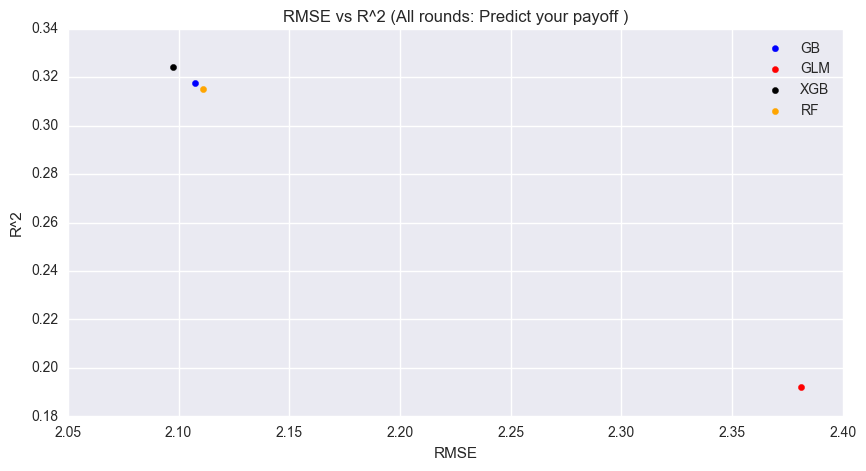

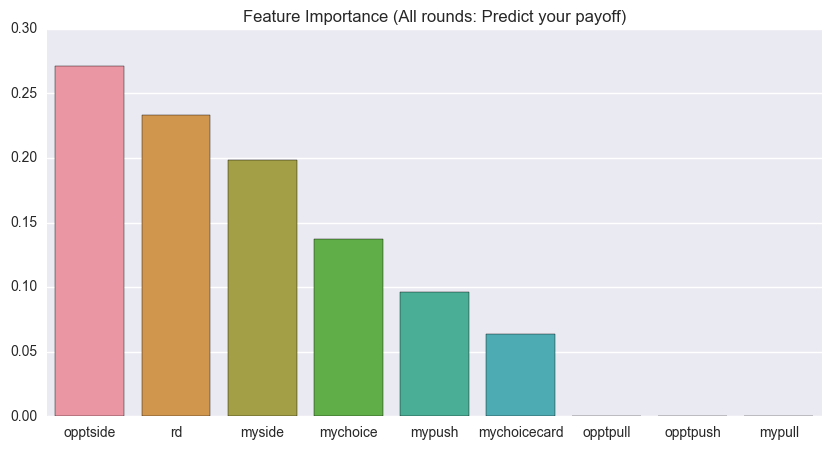

In [118]:
plt.figure(figsize=(10,5))
plt.scatter(best_gb_total_rmse,best_gb_total_r2,label='GB',color='b')
plt.scatter(best_glmnet_total_rmse,best_glmnet_total_r2,label='GLM',color='r')
plt.scatter(best_xgb_total_rmse,best_xgb_total_r2,label='XGB',color='black')
plt.scatter(best_rf_total_rmse,best_rf_total_r2,label='RF',color='orange')
plt.title('RMSE vs R^2 (All rounds: Predict your payoff )')
plt.xlabel('RMSE')
plt.ylabel('R^2')
plt.legend();


plt.figure(figsize=(10,5))
sns.barplot(x=features_weights_sorted_xgb_total,y=sorted_fetures_xgb_total)
plt.title('Feature Importance (All rounds: Predict your payoff)')

> Extreme Gradient Boosting/RF is our best model here (Gradient Boosting was in bestrds past 15).
    - Best XGB RMSE :~2.09
    - Best XGB R^2 :~31.1%
    - [('Feature:', 'opptside', 'Importance:', 0.2715655), ('Feature:', 'rd', 'Importance:', 0.23322684), ('Feature:', 'myside', 'Importance:', 0.19808307), ('Feature:', 'mychoice', 'Importance:', 0.1373802), ('Feature:', 'mypush', 'Importance:', 0.095846646), ('Feature:', 'mychoicecard', 'Importance:', 0.063897766), ('Feature:', 'opptpull', 'Importance:', 0.0), ('Feature:', 'opptpush', 'Importance:', 0.0), ('Feature:', 'mypull', 'Importance:', 0.0)]
    
>Top Three Features (same as for rounds past 15)
    - RD
    - Opptside
    - Myside
    


# Ensemble Method
- Inspiration http://stats.stackexchange.com/questions/139042/ensemble-of-different-kinds-of-regressors-using-scikit-learn-or-any-other-pytho
- For the first 15 rounds, GLM/Elastic net performs the best.
- For rounds past 15, and all rounds, gradient boosting performs the best.
- Use a linear classifier on the trained models to ensemble them.
- Predictions are based on a train test split (single split).
- Need to use the same data , so glmnet will not use scaled data.

In [153]:
%autoreload 2

In [106]:
#best unsclaed glmnet
best_glm_total_model_unscaled = regression_model_total_mypayoff.random_grid_search(model='glm_net',params_dict=glm_net_parameters,iterations=1000)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: Conv

In [158]:
glmnet_predictions_scaled = regression_model_total_mypayoff_scaled.predict(model='glm_net').reshape(-1,1)

/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [160]:
glmnet_predictions =regression_model_total_mypayoff.predict(model='glm_net').reshape(-1,1)


In [161]:
gradient_boost_predictions = regression_model_total_mypayoff.predict(model='gradient_boost').reshape(-1,1)


In [162]:
extreme_gradient_boost_predictions = regression_model_total_mypayoff.predict('extreme_gradient_boost').reshape(-1,1)

In [164]:
random_forest_predictions = regression_model_total_mypayoff.predict(model='random_forest').reshape(-1,1)

In [156]:
#df - dataframe with results of 3 regressors and true output

 from sklearn linear_model
 stacker= linear_model.LinearRegression()
 stacker.fit(df[['predictedSVR', 'predictedLASSO', 'predictedGBR']], df['predicted'

IndentationError: unexpected indent (<ipython-input-156-23fb9752b996>, line 3)

In [170]:
predictions_df = pd.DataFrame(index=range(len(glmnet_prediction_scaled)))
predictions_df['GLM_sclaed']=glmnet_predictions_scaled
predictions_df['GB']=gradient_boost_predictions
predictions_df['RF']=random_forest_predictions
predictions_df['XGB']=extreme_gradient_boost_predictions

In [172]:
stacked_model = linear_model.LinearRegression()

In [ ]:
stacked_model.fit(predictions_df['GLM_sclaed','GB'])

In [112]:
## the y-values are the same between the scaled regression model and not scaled,
ensemble_prediction = glmnet_weight*glmnet_predictions+gradient_boost_weight*gradient_boost_predictions
euclidean(regression_model_total_mypayoff.y_test,ensemble_prediction)/sqrt(len(regression_model_total_mypayoff.y_test))

2.0993284568531769

In [113]:
euclidean(regression_model_total_mypayoff.y_test,gradient_boost_predictions)/\
sqrt(len(regression_model_total_mypayoff.y_test))

2.117620979055598

In [114]:
euclidean(regression_model_total_mypayoff.y_test,glmnet_predictions)/\
sqrt(len(regression_model_total_mypayoff.y_test))

2.234666739966273

In [115]:
4.1089716544919099*.375+3.2039582469505392*.625

3.543338274778553

# Testing

In [116]:
m.predict(X_test)

NameError: name 'm' is not defined